# Verificación de uso de GPU

In [4]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Restringe a TensorFlow a usar solo la primera GPU
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    print("¡TensorFlow utilizará la GPU!")
  except RuntimeError as e:
    # La visibilidad de los dispositivos debe establecerse antes de que se inicialice la GPU
    print(e)
else:
    print("No se encontró GPU. TensorFlow utilizará la CPU.")

1 Physical GPUs, 1 Logical GPU
¡TensorFlow utilizará la GPU!


# Importación de librerias

In [5]:
# Librerías para el modelo
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Carga de datos y pre procesamiento

## Carga de datos

In [ ]:
# Proceso de ETL y Feature Engineering
# Cargar los datos
df = pd.read_excel('//mnt//c//Users//ALEX//Github//Modelo_Viento_LSTM//app_viento//Data//Datos meteorologicos 2024 y 2025.xlsx')
print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26323 entries, 0 to 26322
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               26323 non-null  datetime64[ns]
 1   hora               26323 non-null  object        
 2   temperatura media  26323 non-null  float64       
 3   humedad            26323 non-null  int64         
 4   viento             26323 non-null  float64       
 5   lluvia             26323 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 1.2+ MB
None


,Date,hora,temperatura media,humedad,viento,lluvia
0,2024-01-01,00:30:00,21.8,81,4.8,0.0
1,2024-01-01,01:00:00,21.7,81,4.8,0.0
2,2024-01-01,01:30:00,21.4,82,4.8,0.0
3,2024-01-01,02:00:00,21.2,83,4.8,0.0
4,2024-01-01,02:30:00,21.1,84,4.8,0.0


## Extracción de datos para predicciones en web

In [ ]:
# Extraemos 48 horas de datos para usarlos de ejemplo
# ===================================================================
# 1. Definir los rangos de datos
# ===================================================================

# El modelo LSTM utiliza una ventana de 96 pasos para predecir el paso 97.
# LOOKBACK = 96
# El total de filas que necesitamos considerar es LOOKBACK + 1 = 97.

# - Las filas de -97 a -1 (inclusive) serán el histórico para la predicción.
# - La última fila (-1) es el valor real que queremos predecir.

total_rows_needed = 144

# Extraer el bloque final de 97 filas del DataFrame
final_block = df.tail(total_rows_needed)

# ===================================================================
# 2. Crear el archivo de datos históricos para la app
# ===================================================================

# Este DataFrame contendrá las 96 filas que servirán de entrada al modelo.
# Corresponde a los datos desde el inicio del bloque hasta el penúltimo elemento.
df_historico_para_app = final_block.iloc[:-48] # Tomar todas las filas excepto la última

# Definir el nombre del archivo
csv_historico_path = "Data//historico_para_predecir.csv"

# Guardar en formato CSV sin el índice de pandas
df_historico_para_app.to_csv(csv_historico_path, index=False)

print(f"Archivo de datos históricos guardado exitosamente en: '{csv_historico_path}'")
print(f"Este archivo contiene {len(df_historico_para_app)} filas y se usará como entrada en Streamlit.")


# ===================================================================
# 3. Crear el archivo con el valor real para la comparación
# ===================================================================

# Este DataFrame contendrá solo la última fila, que es el valor real
# que el modelo debería predecir con los datos históricos anteriores.
df_valor_real = final_block.tail(48)

# Definir el nombre del archivo
csv_real_path = "Data//real_para_comparar.csv"

# Guardar en formato CSV sin el índice de pandas
df_valor_real.to_csv(csv_real_path, index=False)

print(f"\nArchivo con el valor real guardado exitosamente en: '{csv_real_path}'")
print("Use este archivo para verificar la predicción de la aplicación.")
print("\nEl valor de viento que la app debería predecir es:")
print(df_valor_real)

Archivo de datos históricos guardado exitosamente en: 'historico_para_predecir.csv'
Este archivo contiene 96 filas y se usará como entrada en Streamlit.

Archivo con el valor real guardado exitosamente en: 'real_para_comparar.csv'
Use este archivo para verificar la predicción de la aplicación.

El valor de viento que la app debería predecir es:
            Date      hora  temperatura media  humedad  viento  lluvia
26275 2025-07-03  12:00:00               19.5       88     1.6     0.0
26276 2025-07-03  12:30:00               20.1       87     1.6     0.0
26277 2025-07-03  13:00:00               20.5       85     1.6     0.0
26278 2025-07-03  13:30:00               21.9       82     3.2     0.0
26279 2025-07-03  14:00:00               22.9       78     3.2     0.0
26280 2025-07-03  14:30:00               24.8       73     3.2     0.0
26281 2025-07-03  15:00:00               25.1       71     3.2     0.0
26282 2025-07-03  15:30:00               24.5       72     6.4     0.0
26283 2025-07-

## Cambios de variables y ordenamiento

In [10]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['hora_str'] = df['hora'].astype(str)
df['hora_delta'] = pd.to_timedelta(df['hora_str'])
df['datetime'] = df['Date'] + df['hora_delta']
df = df.set_index('datetime').sort_index()
df.drop(['Date', 'hora', 'hora_delta','hora_str'], axis=1, inplace=True)

df.head()

,temperatura media,humedad,viento,lluvia
datetime,,,,
2024-01-01 00:30:00,21.8,81,4.8,0.0
2024-01-01 01:00:00,21.7,81,4.8,0.0
2024-01-01 01:30:00,21.4,82,4.8,0.0
2024-01-01 02:00:00,21.2,83,4.8,0.0
2024-01-01 02:30:00,21.1,84,4.8,0.0


In [11]:
df.index.min(), df.index.max()

(Timestamp('2024-01-01 00:30:00'), Timestamp('2025-07-04 11:30:00'))

### Verificcción de outliers

In [12]:
# --- Paso 1: Aislar los datos en la franja horaria del pico ---
# Creamos un índice de tiempo para filtrar.
import datetime as dt
df_pico = df[(df.index.time >= dt.time(10, 0)) & (df.index.time <= dt.time(16, 0))].copy()

In [13]:
# --- Paso 2: Detección de Outliers usando el método IQR ---
# Un outlier se define comúnmente como un punto que está 1.5 veces
# el Rango Intercuartílico (IQR) por encima del tercer cuartil (Q3)
# o por debajo del primer cuartil (Q1).

def find_outliers_iqr(data_series):
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data_series[(data_series < lower_bound) | (data_series > upper_bound)]
    return outliers, lower_bound, upper_bound

# Encontrar outliers para viento y temperatura
outliers_viento, _, _ = find_outliers_iqr(df_pico['viento'])
outliers_temp, _, _ = find_outliers_iqr(df_pico['temperatura media'])

print(f"\nSe encontraron {len(outliers_viento)} outliers para 'viento' en la franja de 12:00-14:00.")
if not outliers_viento.empty:
    print("Valores de viento atípicos (km/h):")
    print(outliers_viento.describe())
    
print(f"\nSe encontraron {len(outliers_temp)} outliers para 'temperatura media' en la franja de 12:00-14:00.")
if not outliers_temp.empty:
    print("Valores de temperatura atípicos (°C):")
    print(outliers_temp.describe())


Se encontraron 0 outliers para 'viento' en la franja de 12:00-14:00.

Se encontraron 0 outliers para 'temperatura media' en la franja de 12:00-14:00.


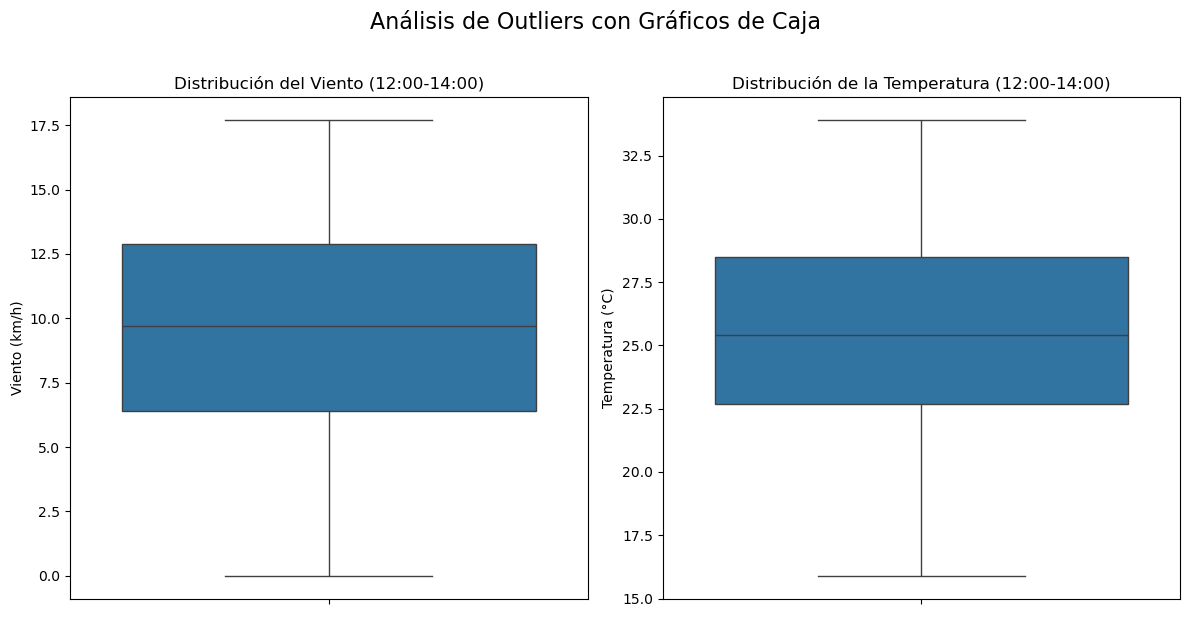

In [14]:
# --- Paso 3: Visualización para confirmar los outliers ---

# Gráfico de Caja (Boxplot) para ver la distribución
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_pico['viento'])
plt.title('Distribución del Viento (12:00-14:00)')
plt.ylabel('Viento (km/h)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_pico['temperatura media'])
plt.title('Distribución de la Temperatura (12:00-14:00)')
plt.ylabel('Temperatura (°C)')

plt.suptitle('Análisis de Outliers con Gráficos de Caja', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

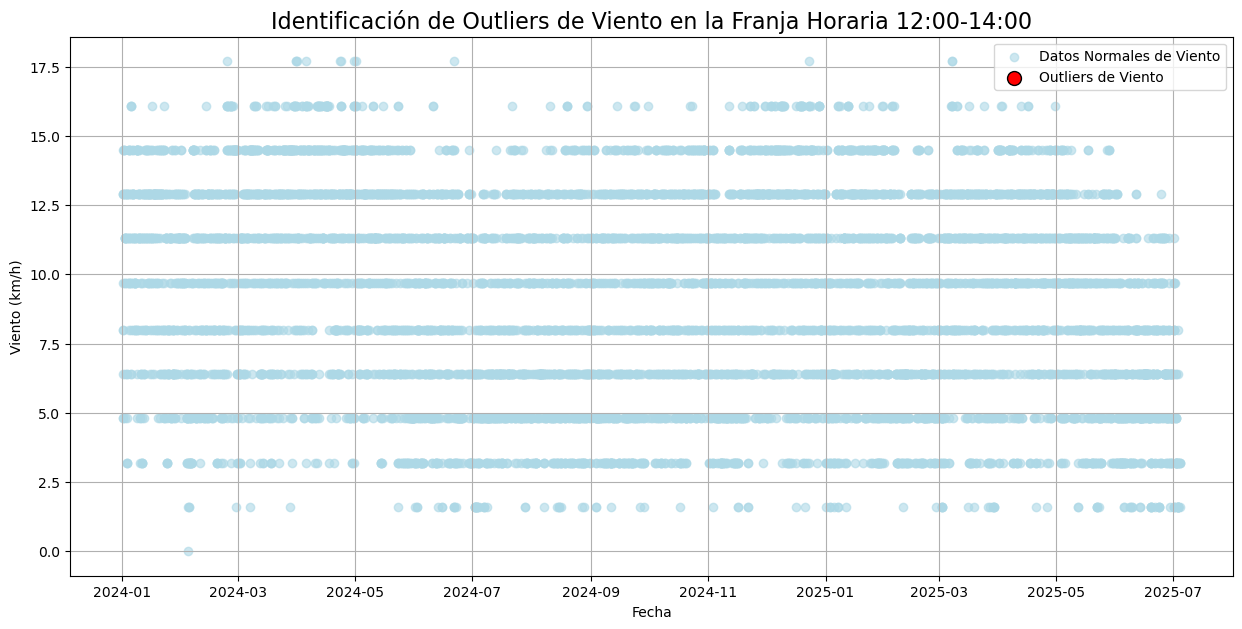

In [15]:
# Gráfico de Dispersión para ver los outliers en el contexto del tiempo
plt.figure(figsize=(15, 7))
# Graficar todos los puntos de la franja horaria
plt.scatter(df_pico.index, df_pico['viento'], color='lightblue', label='Datos Normales de Viento', alpha=0.6)
# Resaltar los outliers encontrados
plt.scatter(outliers_viento.index, outliers_viento, color='red', s=100, edgecolor='black', label='Outliers de Viento')

plt.title('Identificación de Outliers de Viento en la Franja Horaria 12:00-14:00', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Viento (km/h)')
plt.legend()
plt.grid(True)
plt.show()

### Valoree Faltantes

In [16]:
df['hora_del_dia'] = df.index.time

In [17]:
print(df.head())

                     temperatura media  humedad  viento  lluvia hora_del_dia
datetime                                                                    
2024-01-01 00:30:00               21.8       81     4.8     0.0     00:30:00
2024-01-01 01:00:00               21.7       81     4.8     0.0     01:00:00
2024-01-01 01:30:00               21.4       82     4.8     0.0     01:30:00
2024-01-01 02:00:00               21.2       83     4.8     0.0     02:00:00
2024-01-01 02:30:00               21.1       84     4.8     0.0     02:30:00


In [18]:
# --- Paso 1: Agrupar y calcular múltiples agregaciones ---
# Usamos .agg() para calcular la media, la desviación estándar y el conteo a la vez.
analisis_intervalo = df.groupby('hora_del_dia').agg(
    viento_mean=('viento', 'mean'),
    viento_std=('viento', 'std'),
    viento_count=('viento', 'count'),
    temp_mean=('temperatura media', 'mean'),
    temp_std=('temperatura media', 'std'),
    temp_count=('temperatura media', 'count')
).reset_index()

# Preparar para el gráfico
analisis_intervalo['hora_num'] = [t.hour + t.minute/60 for t in analisis_intervalo['hora_del_dia']]
analisis_intervalo = analisis_intervalo.sort_values('hora_num')

In [19]:
# --- Paso 2: Imprimir los datos de la zona crítica para análisis numérico ---
zona_critica = analisis_intervalo[
    (analisis_intervalo['hora_num'] >= 12) & 
    (analisis_intervalo['hora_num'] <= 14)
]
print("\nAnálisis numérico para la franja horaria 12:00 - 14:00:")
zona_critica


Análisis numérico para la franja horaria 12:00 - 14:00:


,hora_del_dia,viento_mean,viento_std,viento_count,temp_mean,temp_std,temp_count,hora_num
24,12:00:00,8.115722,3.059497,547,25.930896,3.775273,547,12.000000
25,12:30:00,8.959598,3.173147,547,26.241865,3.589145,547,12.500000
26,13:00:00,9.808775,3.233450,547,26.397441,3.418988,547,13.000000
27,13:01:00,14.500000,NaN,1,26.100000,NaN,1,13.016667
28,13:30:00,10.514416,3.145159,548,26.446898,3.258056,548,13.500000
29,14:00:00,11.075000,3.041441,548,26.329197,3.156530,548,14.000000


In [20]:
# La condición del filtro: el minuto del índice debe ser 0 o 30.
df_filtrado = df[df.index.minute.isin([0, 30])].copy()

print(f"Número de registros después del filtrado: {len(df_filtrado)}")
num_eliminados = len(df) - len(df_filtrado)
if num_eliminados > 0:
    print(f"Se eliminaron {num_eliminados} registros con marcas de tiempo anómalas.")
else:
    print("No se encontraron registros con marcas de tiempo anómalas. El dataset está limpio.")

# Reemplazar el DataFrame original por la versión filtrada
df = df_filtrado

Número de registros después del filtrado: 26322
Se eliminaron 1 registros con marcas de tiempo anómalas.


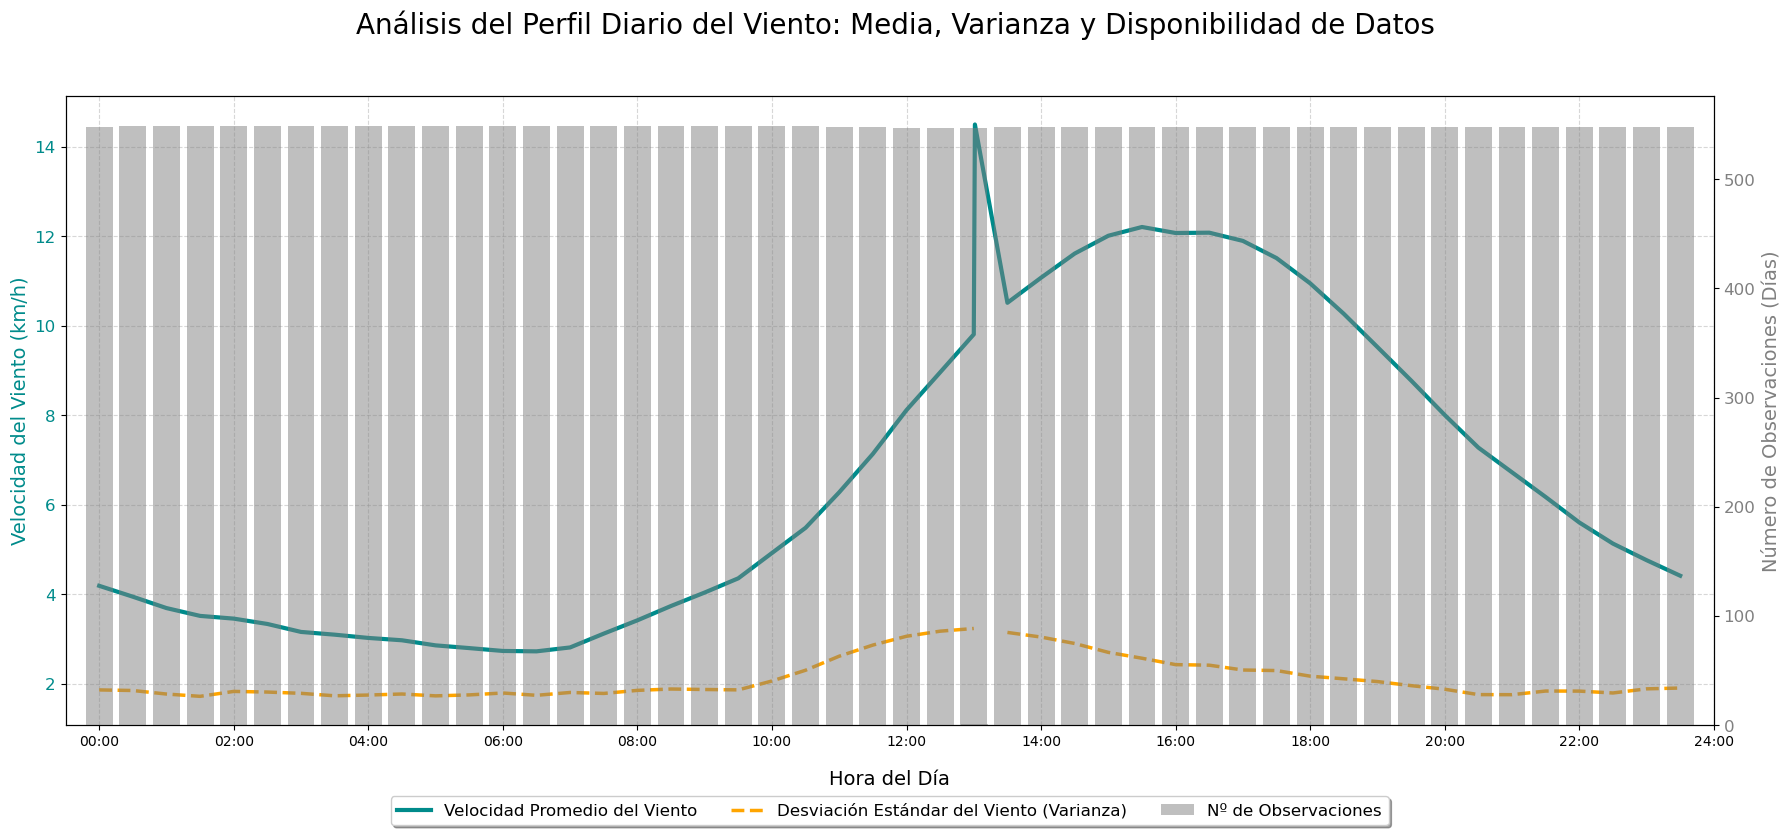

In [21]:
# --- Paso 3: Visualización Combinada de Media, Varianza y Conteo ---
fig, ax1 = plt.subplots(figsize=(18, 9))
fig.suptitle('Análisis del Perfil Diario del Viento: Media, Varianza y Disponibilidad de Datos', fontsize=20, y=0.98)

# Eje principal (izquierdo) para la Media y la Desviación Estándar
color_mean = 'darkcyan'
color_std = 'orange'

ax1.set_xlabel('Hora del Día', fontsize=14, labelpad=15)
ax1.set_ylabel('Velocidad del Viento (km/h)', color=color_mean, fontsize=14)
# Graficar la media del viento
ax1.plot(analisis_intervalo['hora_num'], analisis_intervalo['viento_mean'], 
         color=color_mean, linewidth=3, label='Velocidad Promedio del Viento')
ax1.tick_params(axis='y', labelcolor=color_mean, labelsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)

# Graficar la desviación estándar del viento en el mismo eje
ax1.plot(analisis_intervalo['hora_num'], analisis_intervalo['viento_std'],
         color=color_std, linewidth=2.5, linestyle='--', label='Desviación Estándar del Viento (Varianza)')

# Eje secundario (derecho) para el Conteo de Observaciones
ax2 = ax1.twinx()
color_count = 'gray'
ax2.set_ylabel('Número de Observaciones (Días)', color=color_count, fontsize=14)
# Graficar el conteo como un gráfico de barras
ax2.bar(analisis_intervalo['hora_num'], analisis_intervalo['viento_count'], 
        width=0.4, align='center', color=color_count, alpha=0.5, label='Nº de Observaciones')
ax2.tick_params(axis='y', labelcolor=color_count, labelsize=12)

# Unificar leyendas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper center', 
           bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3, fontsize=12)

# Configurar eje X
ticks_pos = range(0, 25, 2)
ticks_lab = [f'{h:02d}:00' for h in ticks_pos]
plt.xticks(ticks=ticks_pos, labels=ticks_lab, fontsize=12)
plt.xlim(-0.5, 24)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

## Graficos del EDA

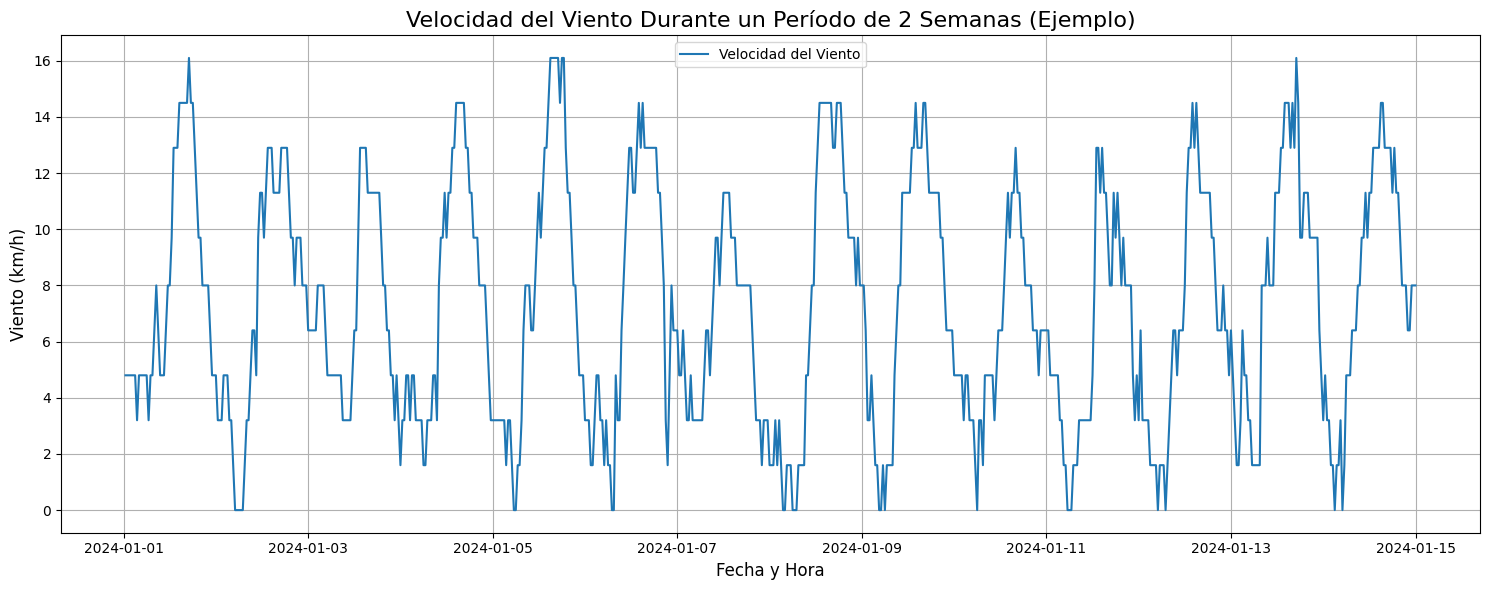

In [ ]:
# --- Gráfico 1: Visualización de la Serie Temporal (una semana de ejemplo) ---
# Se toma una muestra de 2 semanas para observar claramente el patrón diario.
# 48 registros/día * 14 días = 672 registros
df_sample = df.iloc[:672]

plt.figure(figsize=(15, 6))
plt.plot(df_sample.index, df_sample['viento'], label='Velocidad del Viento')
plt.title('Velocidad del Viento Durante un Período de 2 Semanas (Ejemplo)', fontsize=16)
plt.xlabel('Fecha y Hora', fontsize=12)
plt.ylabel('Viento (km/h)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

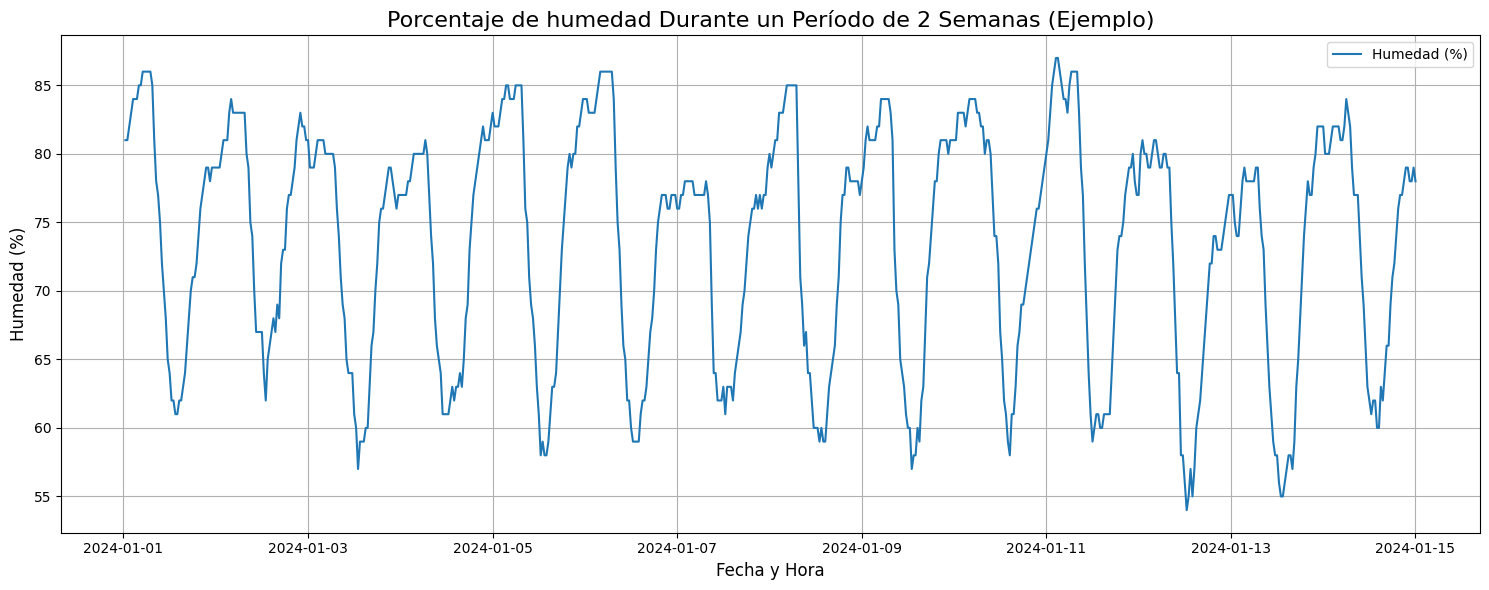

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_sample.index, df_sample["humedad"], label='Humedad (%)')
plt.title('Porcentaje de humedad Durante un Período de 2 Semanas (Ejemplo)', fontsize=16)
plt.xlabel('Fecha y Hora', fontsize=12)
plt.ylabel('Humedad (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

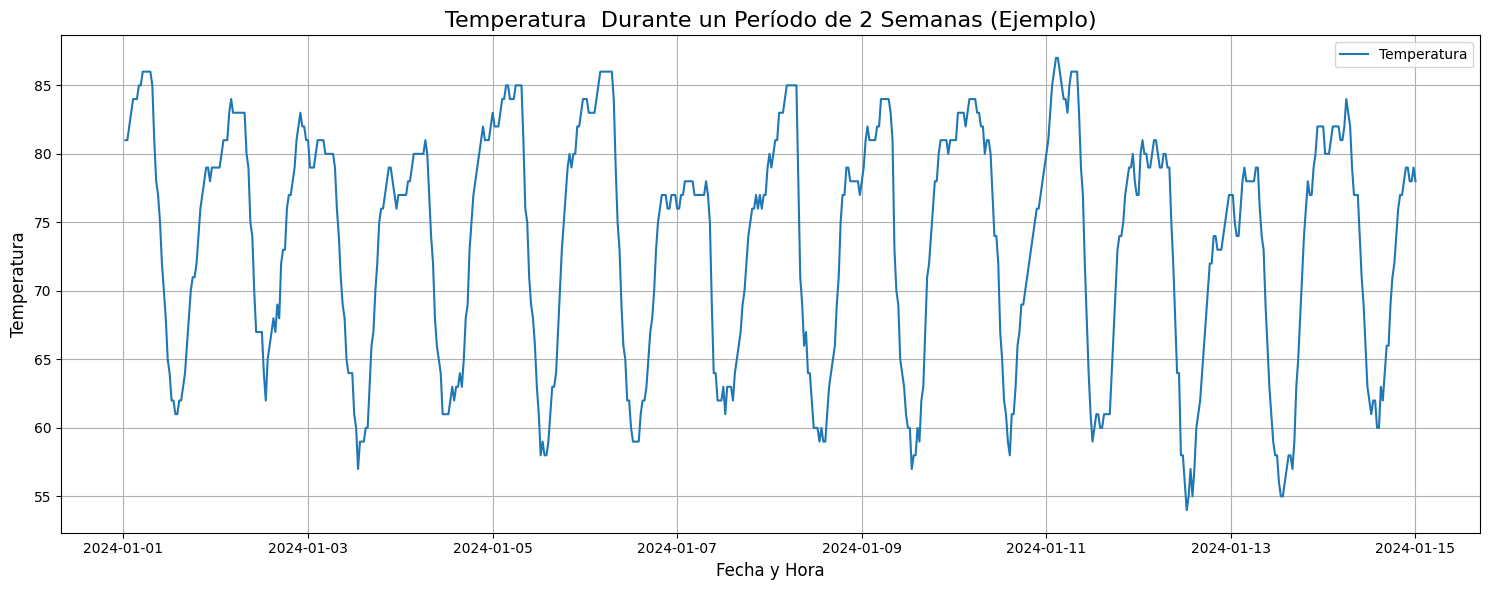

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_sample.index, df_sample["humedad"], label='Temperatura')
plt.title('Temperatura  Durante un Período de 2 Semanas (Ejemplo)', fontsize=16)
plt.xlabel('Fecha y Hora', fontsize=12)
plt.ylabel('Temperatura', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

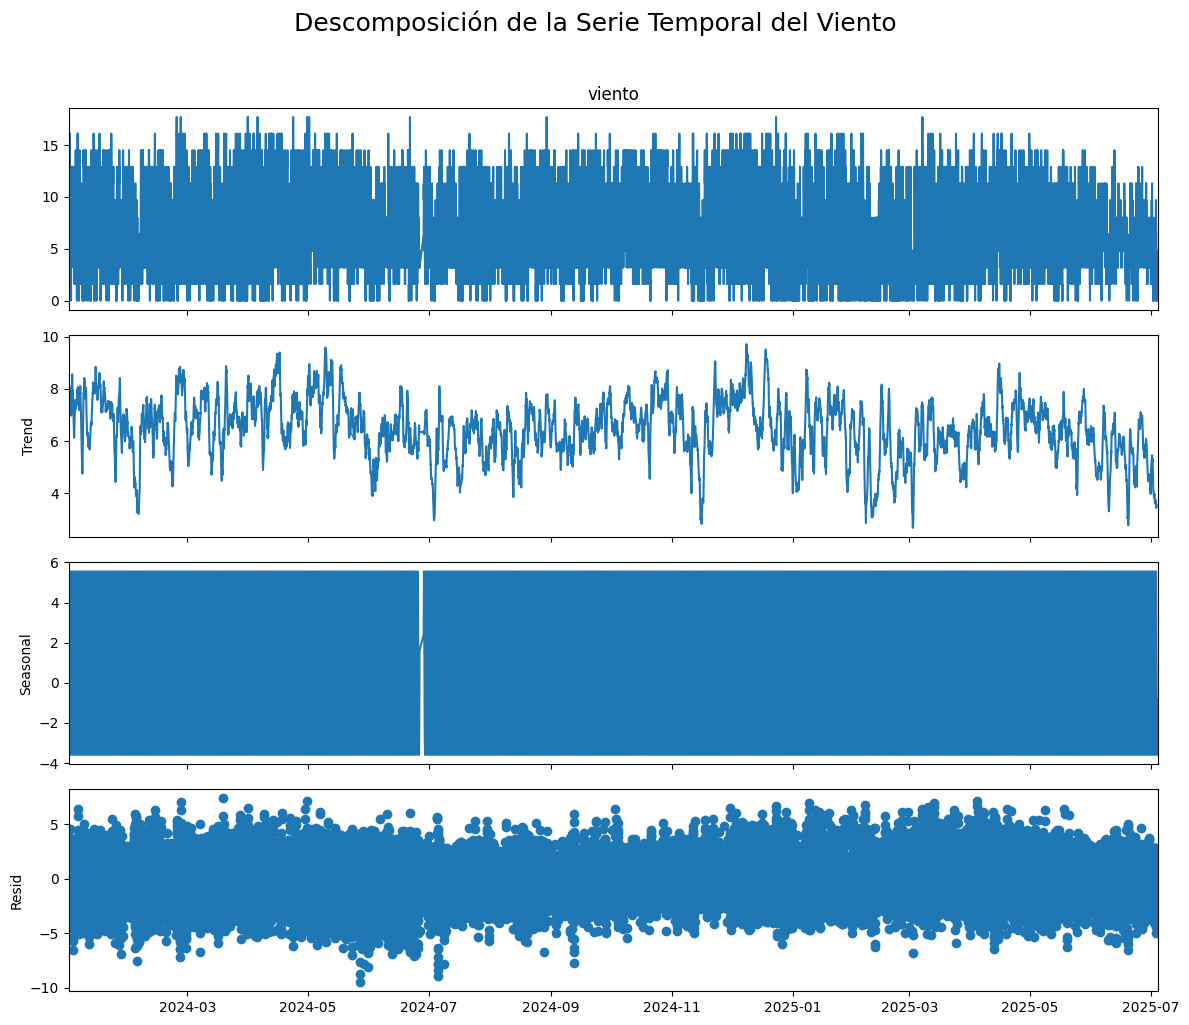

In [ ]:
# --- Gráfico 2: Descomposición Estacional ---
# Esta técnica separa la serie en sus componentes principales:
# Tendencia: El comportamiento a largo plazo.
# Estacionalidad: El patrón repetitivo (en nuestro caso, diario).
# Residuo: El ruido o la aleatoriedad que queda.
from statsmodels.tsa.seasonal import seasonal_decompose

# Usamos 'period=48' porque tenemos 48 mediciones por día (cada 30 min).
# Usamos solo los datos de viento para la descomposición.
# 'additive' es un buen modelo inicial para este tipo de datos.
decomposition = seasonal_decompose(df['viento'], model='additive', period=48)

fig = decomposition.plot()
fig.set_size_inches(12, 10)
fig.suptitle('Descomposición de la Serie Temporal del Viento', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

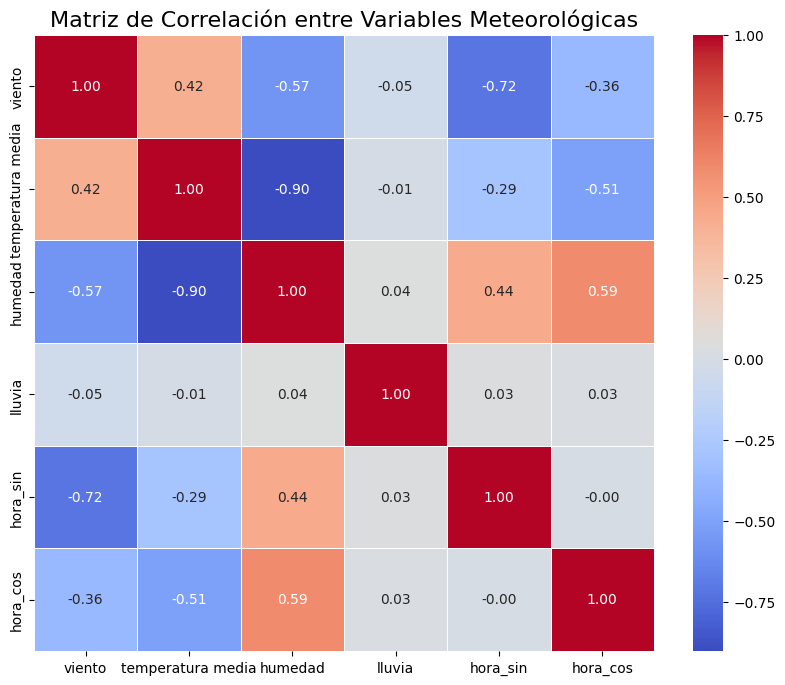

In [ ]:
# --- Gráfico 3: Matriz de Correlación ---
# Se calculan las características cíclicas aquí temporalmente para incluirlas en la correlación.
# Esto nos muestra cómo se relacionan todas las variables que usará el modelo.
df_corr = df.copy()
df_corr['hora_sin'] = np.sin(2 * np.pi * (df_corr.index.hour + df_corr.index.minute/60) / 24)
df_corr['hora_cos'] = np.cos(2 * np.pi * (df_corr.index.hour + df_corr.index.minute/60) / 24)

# Seleccionar las variables de interés
correlation_features = ['viento', 'temperatura media', 'humedad', 'lluvia', 'hora_sin', 'hora_cos']
correlation_matrix = df_corr[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación entre Variables Meteorológicas', fontsize=16)
plt.show()

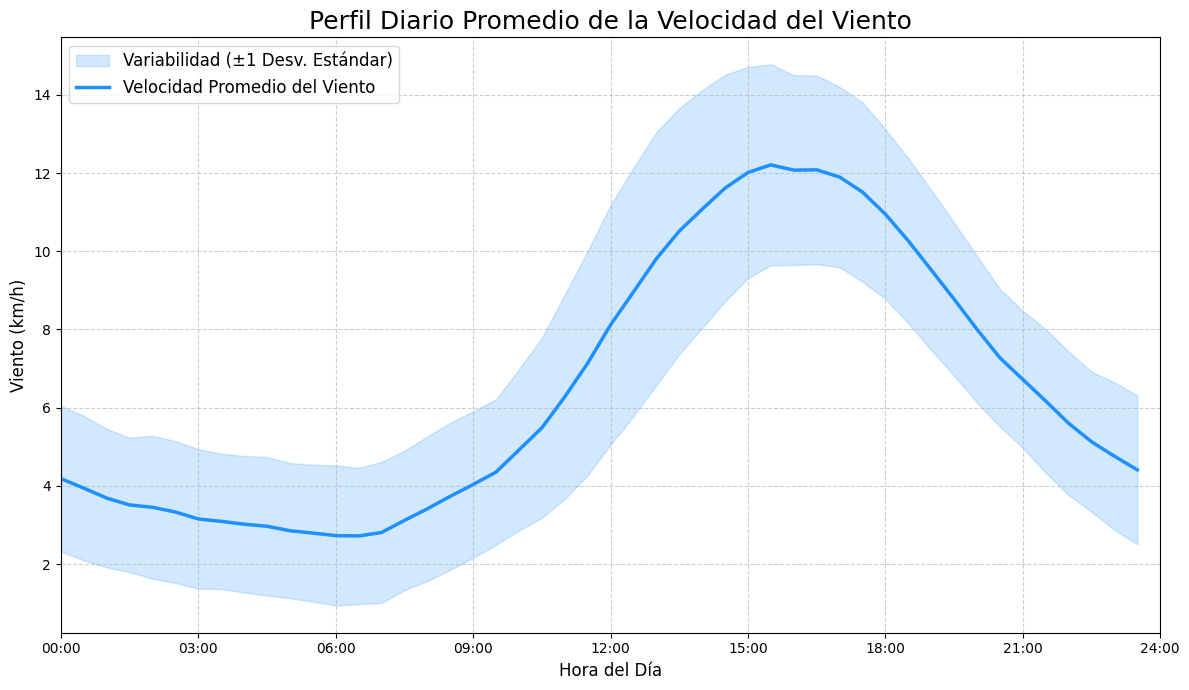

In [ ]:
df_new = df.copy()

# Crear una columna para la hora del día (ej. '00:30', '01:00')
df_new['hora_del_dia'] = df_new.index.time

# Agrupar por la hora del día y calcular la media y la desviación estándar
perfil_diario = df_new.groupby('hora_del_dia')['viento'].agg(['mean', 'std']).reset_index()

# Convertir la hora a un formato que se pueda graficar fácilmente
perfil_diario['hora_num'] = [t.hour + t.minute/60 for t in perfil_diario['hora_del_dia']]
perfil_diario = perfil_diario.sort_values('hora_num')

# Calcular los límites del intervalo de confianza (media +/- 1 std)
perfil_diario['lower'] = perfil_diario['mean'] - perfil_diario['std']
perfil_diario['upper'] = perfil_diario['mean'] + perfil_diario['std']

# --- Crear el Gráfico ---
plt.figure(figsize=(12, 7))
# Dibujar el intervalo de confianza como un área sombreada
plt.fill_between(perfil_diario['hora_num'], perfil_diario['lower'], perfil_diario['upper'],
                 color='dodgerblue', alpha=0.2, label='Variabilidad (±1 Desv. Estándar)')

# Dibujar la línea de la media
plt.plot(perfil_diario['hora_num'], perfil_diario['mean'],
         color='dodgerblue', linewidth=2.5, label='Velocidad Promedio del Viento')

# Mejorar la estética del gráfico
plt.title('Perfil Diario Promedio de la Velocidad del Viento', fontsize=18)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Viento (km/h)', fontsize=12)
plt.xticks(ticks=range(0, 25, 3), labels=[f'{h:02d}:00' for h in range(0, 25, 3)])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.xlim(0, 24)
plt.tight_layout()
plt.show()
# Guardar la figura para la presentación
# plt.savefig("grafico_perfil_diario_promedio.png")

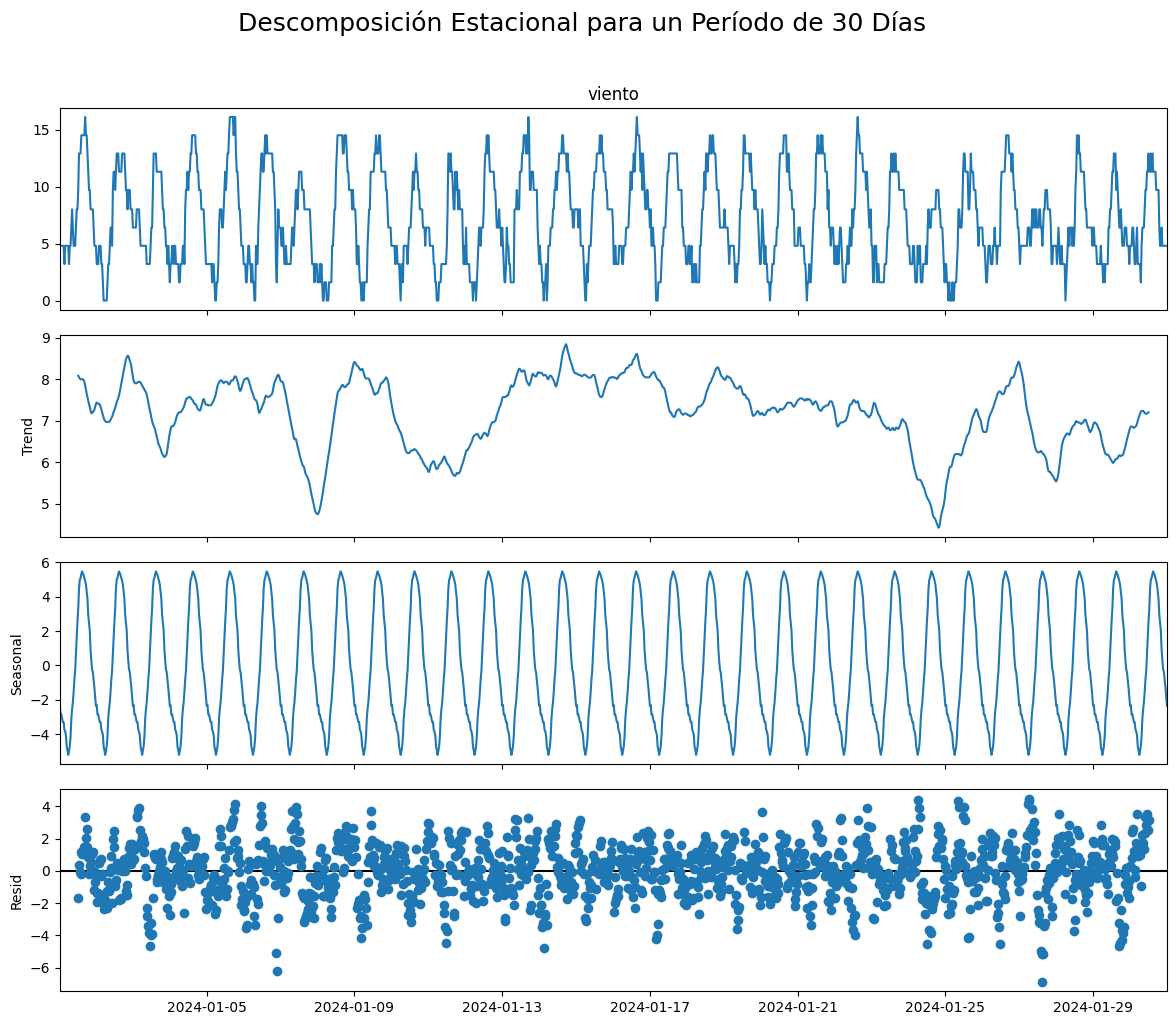

In [ ]:
# Tomar una muestra de 30 días para una mejor visualización de la estacionalidad
# 48 registros/día * 30 días = 1440 registros
df_sample_month = df.iloc[:1440]

decomposition_short = seasonal_decompose(df_sample_month['viento'], model='additive', period=48)

fig_short = decomposition_short.plot()
fig_short.set_size_inches(12, 10)
fig_short.suptitle('Descomposición Estacional para un Período de 30 Días', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

## Pruebas estadisticas

In [22]:
from statsmodels.tsa.stattools import adfuller

print("\n--- Realizando Pruebas Numéricas para Estacionalidad ---")

# --- Prueba 1: Test de Dickey-Fuller Aumentada (ADF) sobre los datos originales ---
# Hipótesis Nula (H0): La serie tiene una raíz unitaria (es no estacionaria).
# Hipótesis Alternativa (H1): La serie es estacionaria.
# Si el p-valor es bajo (< 0.05), rechazamos H0 y concluimos que la serie es estacionaria.

print("\n1. Prueba ADF sobre los datos originales:")
adf_result_original = adfuller(df['viento'])
print(f'   - ADF Statistic: {adf_result_original[0]:.4f}')
print(f'   - p-value: {adf_result_original[1]:.4f}')
print('   - Conclusión:', 'La serie es ESTACIONARIA.' if adf_result_original[1] < 0.05 else 'La serie es NO ESTACIONARIA.')


--- Realizando Pruebas Numéricas para Estacionalidad ---

1. Prueba ADF sobre los datos originales:
   - ADF Statistic: -9.7165
   - p-value: 0.0000
   - Conclusión: La serie es ESTACIONARIA.


In [23]:
# --- Prueba 2: Aplicar Diferenciación Estacional ---
# Se resta el valor de hace 48 períodos (24 horas) para eliminar el patrón diario.
# .dropna() elimina los primeros 48 valores que serán NaN.
viento_diff_seasonal = df['viento'].diff(48).dropna()

# --- Prueba 3: Test ADF sobre los datos con diferenciación estacional ---
# Si la serie se vuelve estacionaria después de esto, hemos confirmado
# numéricamente la presencia de una fuerte estacionalidad con período 48.

print("\n2. Prueba ADF sobre los datos con diferenciación estacional (periodo=48):")
adf_result_seasonal_diff = adfuller(viento_diff_seasonal)
print(f'   - ADF Statistic: {adf_result_seasonal_diff[0]:.4f}')
print(f'   - p-value: {adf_result_seasonal_diff[1]:.4f}')
print('   - Conclusión:', 'La serie diferenciada es ESTACIONARIA.' if adf_result_seasonal_diff[1] < 0.05 else 'La serie diferenciada es NO ESTACIONARIA.')

if adf_result_original[1] > 0.05 and adf_result_seasonal_diff[1] < 0.05:
    print("\n**VEREDICTO NUMÉRICO:** El hecho de que la serie original sea no estacionaria y la serie con diferenciación estacional sea estacionaria, **confirma con alta confianza estadística la presencia de una estacionalidad con un ciclo de 48 períodos (24 horas).**")
else:
    print("\n**VEREDICTO NUMÉRICO:** Las pruebas ADF no confirman de manera concluyente la estacionalidad. Se debe confiar más en la evidencia visual.")


2. Prueba ADF sobre los datos con diferenciación estacional (periodo=48):
   - ADF Statistic: -27.2861
   - p-value: 0.0000
   - Conclusión: La serie diferenciada es ESTACIONARIA.

**VEREDICTO NUMÉRICO:** Las pruebas ADF no confirman de manera concluyente la estacionalidad. Se debe confiar más en la evidencia visual.


In [24]:
print(df.describe())

       temperatura media       humedad        viento        lluvia
count       26322.000000  26322.000000  26322.000000  26322.000000
mean           21.554893     77.788048      6.460778      0.001360
std             4.157333     10.040805      3.972250      0.029734
min            10.600000     46.000000      0.000000      0.000000
25%            18.100000     70.000000      3.200000      0.000000
50%            21.300000     80.000000      4.800000      0.000000
75%            24.300000     86.000000      9.700000      0.000000
max            33.900000     95.000000     17.700000      1.800000


## Comparación de variables

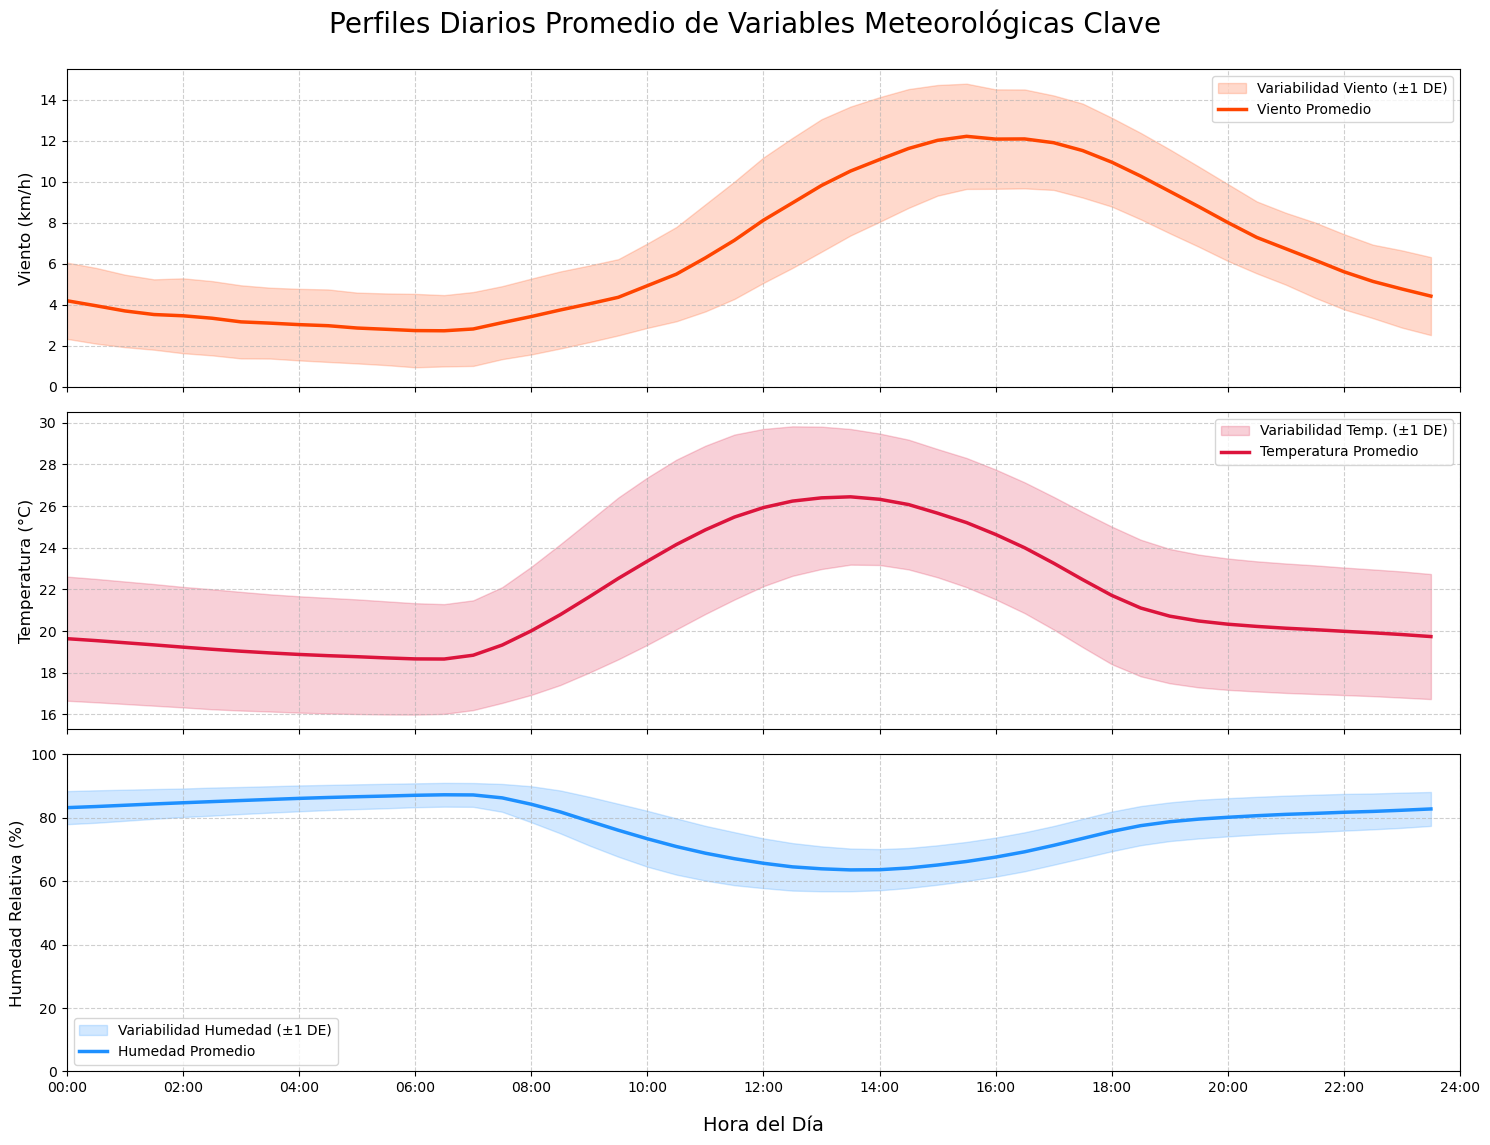

In [25]:
# --- Paso 1: Calcular los perfiles para cada variable ---
# (Reutilizamos la columna 'hora_del_dia' si ya existe, si no, la creamos)
if 'hora_del_dia' not in df.columns:
    df['hora_del_dia'] = df.index.time

# Agrupar por hora y calcular media y std para las tres variables a la vez
perfiles_diarios = df.groupby('hora_del_dia').agg({
    'viento': ['mean', 'std'],
    'temperatura media': ['mean', 'std'],
    'humedad': ['mean', 'std']
}).reset_index()

# Renombrar columnas para un acceso más fácil (ej. 'viento_mean', 'viento_std')
perfiles_diarios.columns = ['_'.join(col).strip('_') for col in perfiles_diarios.columns.values]

# Preparar el eje numérico para el gráfico
perfiles_diarios['hora_num'] = [t.hour + t.minute/60 for t in perfiles_diarios['hora_del_dia']]
perfiles_diarios = perfiles_diarios.sort_values('hora_num')

# --- Paso 2: Crear la figura con 3 subplots que comparten el eje X ---
# sharex=True es el parámetro clave para alinear los gráficos
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Perfiles Diarios Promedio de Variables Meteorológicas Clave', fontsize=20, y=0.95)

# --- Subplot 1: Viento ---
ax1 = axes[0]
ax1.fill_between(perfiles_diarios['hora_num'], 
                 perfiles_diarios['viento_mean'] - perfiles_diarios['viento_std'], 
                 perfiles_diarios['viento_mean'] + perfiles_diarios['viento_std'],
                 color='orangered', alpha=0.2, label='Variabilidad Viento (±1 DE)')
ax1.plot(perfiles_diarios['hora_num'], perfiles_diarios['viento_mean'], 
         color='orangered', linewidth=2.5, label='Viento Promedio')
ax1.set_ylabel('Viento (km/h)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()
ax1.set_ylim(bottom=0) # El viento no puede ser negativo

# --- Subplot 2: Temperatura ---
ax2 = axes[1]
ax2.fill_between(perfiles_diarios['hora_num'], 
                 perfiles_diarios['temperatura media_mean'] - perfiles_diarios['temperatura media_std'], 
                 perfiles_diarios['temperatura media_mean'] + perfiles_diarios['temperatura media_std'],
                 color='crimson', alpha=0.2, label='Variabilidad Temp. (±1 DE)')
ax2.plot(perfiles_diarios['hora_num'], perfiles_diarios['temperatura media_mean'], 
         color='crimson', linewidth=2.5, label='Temperatura Promedio')
ax2.set_ylabel('Temperatura (°C)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

# --- Subplot 3: Humedad ---
ax3 = axes[2]
ax3.fill_between(perfiles_diarios['hora_num'], 
                 perfiles_diarios['humedad_mean'] - perfiles_diarios['humedad_std'], 
                 perfiles_diarios['humedad_mean'] + perfiles_diarios['humedad_std'],
                 color='dodgerblue', alpha=0.2, label='Variabilidad Humedad (±1 DE)')
ax3.plot(perfiles_diarios['hora_num'], perfiles_diarios['humedad_mean'], 
         color='dodgerblue', linewidth=2.5, label='Humedad Promedio')
ax3.set_ylabel('Humedad Relativa (%)', fontsize=12)
ax3.grid(True, linestyle='--', alpha=0.6)
ax3.legend()
ax3.set_ylim(0, 100) # La humedad está entre 0 y 100

# --- Ajustes Finales ---
# Configurar el eje X compartido
plt.xlabel('Hora del Día', fontsize=14, labelpad=15)
ticks_pos = range(0, 25, 2)
ticks_lab = [f'{h:02d}:00' for h in ticks_pos]
plt.xticks(ticks=ticks_pos, labels=ticks_lab)
plt.xlim(0, 24)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajustar para que el título no se superponga
plt.show()

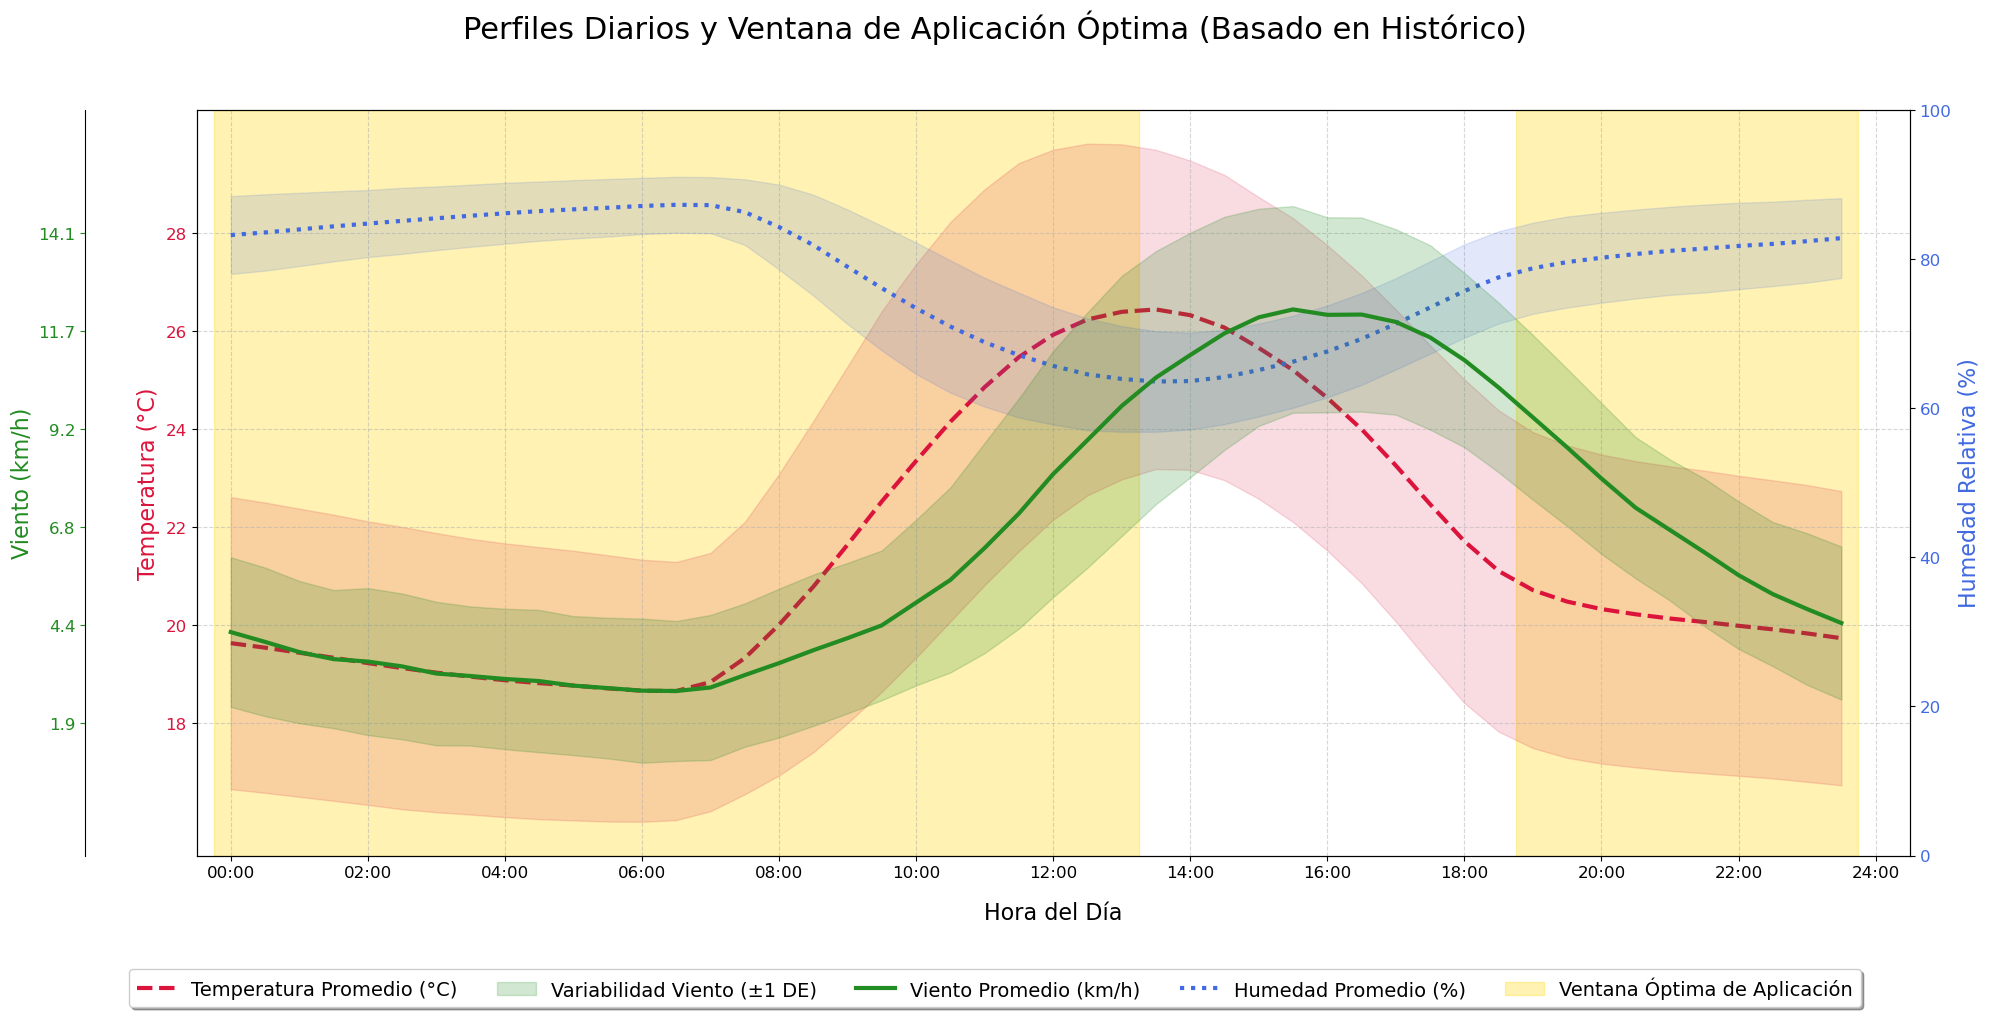

In [26]:
# --- Paso 1: Calcular los perfiles (si no se ha hecho antes) ---
if 'hora_del_dia' not in df.columns:
    df['hora_del_dia'] = df.index.time

perfiles_diarios = df.groupby('hora_del_dia').agg({
    'viento': ['mean', 'std'],
    'temperatura media': ['mean', 'std'],
    'humedad': ['mean', 'std']
}).reset_index()

perfiles_diarios.columns = ['_'.join(col).strip('_') for col in perfiles_diarios.columns.values]
perfiles_diarios['hora_num'] = [t.hour + t.minute/60 for t in perfiles_diarios['hora_del_dia']]
perfiles_diarios = perfiles_diarios.sort_values('hora_num')

# --- Paso 1.5: Calcular la Zona Óptima de Convergencia ---
# Definir las condiciones agronómicas deseadas
VIENTO_MAX_OPTIMO = 10.0
TEMP_MAX_OPTIMA = 30.0
HUM_MIN_OPTIMA = 50.0
HUM_MAX_OPTIMA = 100.0

# Crear una columna booleana en el DataFrame de perfiles que es True
# si la MEDIA de todas las variables está dentro de los rangos óptimos.
perfiles_diarios['Zona_Optima'] = (
    (perfiles_diarios['viento_mean'] < VIENTO_MAX_OPTIMO) &
    (perfiles_diarios['temperatura media_mean'] < TEMP_MAX_OPTIMA) &
    (perfiles_diarios['humedad_mean'] >= HUM_MIN_OPTIMA) &
    (perfiles_diarios['humedad_mean'] <= HUM_MAX_OPTIMA)
)

# Identificar los bloques contiguos donde las condiciones son óptimas
condicion = perfiles_diarios['Zona_Optima']
bloques = (condicion != condicion.shift()).cumsum()
rangos_optimos_df = perfiles_diarios[condicion].groupby(bloques[condicion]).agg(
    inicio=('hora_num', 'first'),
    fin=('hora_num', 'last')
)

# --- Paso 2: Escalar el viento para que coincida con el rango de la temperatura ---
# En lugar de alinear medias, alinearemos los rangos (min a max) para una mejor superposición visual.
temp_min, temp_max = perfiles_diarios['temperatura media_mean'].min(), perfiles_diarios['temperatura media_mean'].max()
viento_min, viento_max = perfiles_diarios['viento_mean'].min(), perfiles_diarios['viento_mean'].max()

# Función de escalado
def scale_series(series, old_min, old_max, new_min, new_max):
    return (series - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

# Escalar la media y la desviación estándar del viento al rango de la temperatura
perfiles_diarios['viento_mean_escalado'] = scale_series(
    perfiles_diarios['viento_mean'], viento_min, viento_max, temp_min, temp_max
)
# Para la desviación, solo aplicamos el factor de escala del rango
factor_escala_std = (temp_max - temp_min) / (viento_max - viento_min)
perfiles_diarios['viento_std_escalado'] = perfiles_diarios['viento_std'] * factor_escala_std


# --- Paso 3: Crear la figura y los ejes ---
# Se crea una figura principal (fig) y un conjunto de ejes primarios (ax_temp).
fig, ax_temp = plt.subplots(figsize=(20, 10))
fig.suptitle('Perfiles Diarios y Ventana de Aplicación Óptima (Basado en Histórico)', fontsize=22, y=0.98)

# --- Definición de una paleta de colores clara para cada variable ---
color_temp = 'crimson'
color_viento = 'forestgreen'
color_humedad = 'royalblue'
color_optimo = 'gold' # Color para la zona óptima

# --- Paso 4: Graficar en el Eje Y Primario (Izquierda - Temperatura) ---
# Se grafica la variabilidad (área sombreada) y la media de la temperatura.
ax_temp.fill_between(perfiles_diarios['hora_num'], 
                     perfiles_diarios['temperatura media_mean'] - perfiles_diarios['temperatura media_std'], 
                     perfiles_diarios['temperatura media_mean'] + perfiles_diarios['temperatura media_std'],
                     color=color_temp, alpha=0.15, label='_nolegend_') # Sin etiqueta para no duplicar en leyenda
ax_temp.plot(perfiles_diarios['hora_num'], perfiles_diarios['temperatura media_mean'], 
             color=color_temp, linewidth=3, linestyle='--', label='Temperatura Promedio (°C)')

# Configuración del eje de Temperatura
ax_temp.set_xlabel('Hora del Día', fontsize=16, labelpad=15)
ax_temp.set_ylabel('Temperatura (°C)', color=color_temp, fontsize=16)
ax_temp.tick_params(axis='y', labelcolor=color_temp, labelsize=12)
ax_temp.grid(True, linestyle='--', alpha=0.5)

# --- Paso 5: Graficar en el Eje Y Secundario (Derecha - Humedad) ---
# Se crea un segundo eje Y que comparte el mismo eje X.
ax_hum = ax_temp.twinx()
ax_hum.fill_between(perfiles_diarios['hora_num'], 
                    perfiles_diarios['humedad_mean'] - perfiles_diarios['humedad_std'], 
                    perfiles_diarios['humedad_mean'] + perfiles_diarios['humedad_std'],
                    color=color_humedad, alpha=0.15, label='_nolegend_')
ax_hum.plot(perfiles_diarios['hora_num'], perfiles_diarios['humedad_mean'], 
            color=color_humedad, linewidth=3, linestyle=':', label='Humedad Promedio (%)')

# Configuración del eje de Humedad
ax_hum.set_ylabel('Humedad Relativa (%)', color=color_humedad, fontsize=16)
ax_hum.tick_params(axis='y', labelcolor=color_humedad, labelsize=12)
ax_hum.set_ylim(0, 100) # La humedad tiene un rango fijo de 0-100.

# --- Paso 6: Graficar en el Tercer Eje Y (Izquierda Desplazada - Viento) ---
# Se crea un tercer eje que también comparte el eje X.
ax_viento = ax_temp.twinx()

# Se grafica el Viento ESCALADO para que coincida visualmente con la temperatura.
ax_viento.fill_between(perfiles_diarios['hora_num'], 
                       perfiles_diarios['viento_mean_escalado'] - perfiles_diarios['viento_std_escalado'], 
                       perfiles_diarios['viento_mean_escalado'] + perfiles_diarios['viento_std_escalado'],
                       color=color_viento, alpha=0.2, label='Variabilidad Viento (±1 DE)')
ax_viento.plot(perfiles_diarios['hora_num'], perfiles_diarios['viento_mean_escalado'], 
               color=color_viento, linewidth=3, linestyle='-', label='Viento Promedio (km/h)')

# --- Configuración del eje de Viento (el "truco" principal) ---
# Se ocultan todos los elementos del eje excepto la columna vertebral izquierda ('spine').
ax_viento.spines['right'].set_visible(False)
ax_viento.spines['top'].set_visible(False)
ax_viento.spines['bottom'].set_visible(False)
# Se mueve físicamente la columna vertebral izquierda 80 puntos hacia afuera.
ax_viento.spines['left'].set_position(('outward', 80))
ax_viento.yaxis.set_ticks_position('left')
ax_viento.yaxis.set_label_position('left')

# --- Control Manual de Ticks para alineación perfecta ---
# Se define un rango de ticks para el eje principal (Temperatura).
# Este rango debe ajustarse según los datos. ej. desde el min al max de temperatura.
temp_min_rounded = np.floor(perfiles_diarios['temperatura media_mean'].min())
temp_max_rounded = np.ceil(perfiles_diarios['temperatura media_mean'].max())
temp_ticks = np.arange(temp_min_rounded, temp_max_rounded + 2, 2) # Ticks cada 2 grados
ax_temp.set_yticks(temp_ticks)

# Se usan las MISMAS POSICIONES para los ticks del eje del viento.
ax_viento.set_yticks(temp_ticks)

# Función para des-escalar los valores de los ticks del viento
def descale_value(scaled_value, old_min, old_max, new_min, new_max):
    return ((scaled_value - new_min) / (new_max - new_min)) * (old_max - old_min) + old_min

# Se calculan las etiquetas correctas para el viento des-escalando los ticks de temperatura.
viento_labels = [f'{descale_value(tick, viento_min, viento_max, temp_min, temp_max):.1f}' for tick in temp_ticks]
ax_viento.set_yticklabels(viento_labels, fontsize=12)

# Se sincronizan los límites de los ejes de la izquierda para que las escalas coincidan.
ax_viento.set_ylim(ax_temp.get_ylim())

# Se configura la etiqueta del eje del viento para que sea simétrica a la de temperatura.
ax_viento.set_ylabel('Viento (km/h)', color=color_viento, fontsize=16)
ax_viento.tick_params(axis='y', labelcolor=color_viento, colors=color_viento)


# --- Paso 7: Unificar Leyendas y Ajustes Finales ---
# Sombrear los rangos donde TODAS las condiciones convergen
if not rangos_optimos_df.empty:
    for _, rango in rangos_optimos_df.iterrows():
        ax_temp.axvspan(rango['inicio'] - 0.25, rango['fin'] + 0.25, 
                        color=color_optimo, alpha=0.3, zorder=0)

# Se recolectan los 'handles' y 'labels' de cada uno de los tres ejes.
lines, labels = ax_temp.get_legend_handles_labels()
lines2, labels2 = ax_hum.get_legend_handles_labels()
lines3, labels3 = ax_viento.get_legend_handles_labels()

# Crear un manejador de leyenda "ficticio" para la zona sombreada
import matplotlib.patches as mpatches
optimo_patch = mpatches.Patch(color=color_optimo, alpha=0.3, label='Ventana Óptima de Aplicación')

# Combinar todas las leyendas, añadiendo la de la zona óptima
all_handles = lines + lines3 + lines2 + [optimo_patch]
all_labels = labels + labels3 + labels2 + ['Ventana Óptima de Aplicación']

fig.legend(handles=all_handles, labels=all_labels,
           loc='upper center', bbox_to_anchor=(0.5, 0.03),
           fancybox=True, shadow=True, ncol=5, fontsize=14)

# Configuración final del eje X.
ticks_pos = range(0, 25, 2)
ticks_lab = [f'{h:02d}:00' for h in ticks_pos]
ax_temp.set_xticks(ticks_pos)
ax_temp.set_xticklabels(ticks_lab, fontsize=12)
ax_temp.set_xlim(-0.5, 24.5)

# Se ajusta el layout para dar espacio a la leyenda y al título.
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

## Frecuenia de condiciones óptimas

### Visualización por medias

In [27]:
# Definir las condiciones agronómicas óptimas
VIENTO_MAX = 10.0
TEMP_MAX = 30.0
HUM_MIN = 50.0
HUM_MAX = 100.0

# Crear una copia del DataFrame para no alterar el original
df_analisis = df.copy()

# Crear una columna booleana que sea 'True' solo si TODAS las condiciones se cumplen
df_analisis['Condicion_Optima'] = (
    (df_analisis['viento'] < VIENTO_MAX) &
    (df_analisis['temperatura media'] < TEMP_MAX) &
    (df_analisis['humedad'] > HUM_MIN) &
    (df_analisis['humedad'] <= HUM_MAX)
)

In [28]:
# Agrupar por hora del día y calcular la frecuencia
# La columna 'Condicion_Optima' tiene valores de 1 (True) y 0 (False).
# Al calcular la media, obtenemos la proporción de veces que la condición fue True.
df_analisis['hora_del_dia'] = df_analisis.index.time
frecuencia_optima = df_analisis.groupby('hora_del_dia')['Condicion_Optima'].mean().reset_index()

# Convertir la frecuencia a porcentaje
frecuencia_optima['Probabilidad_Optima_%'] = frecuencia_optima['Condicion_Optima'] * 100

# Preparar para el gráfico
frecuencia_optima['hora_num'] = [t.hour + t.minute/60 for t in frecuencia_optima['hora_del_dia']]
frecuencia_optima = frecuencia_optima.sort_values('hora_num')

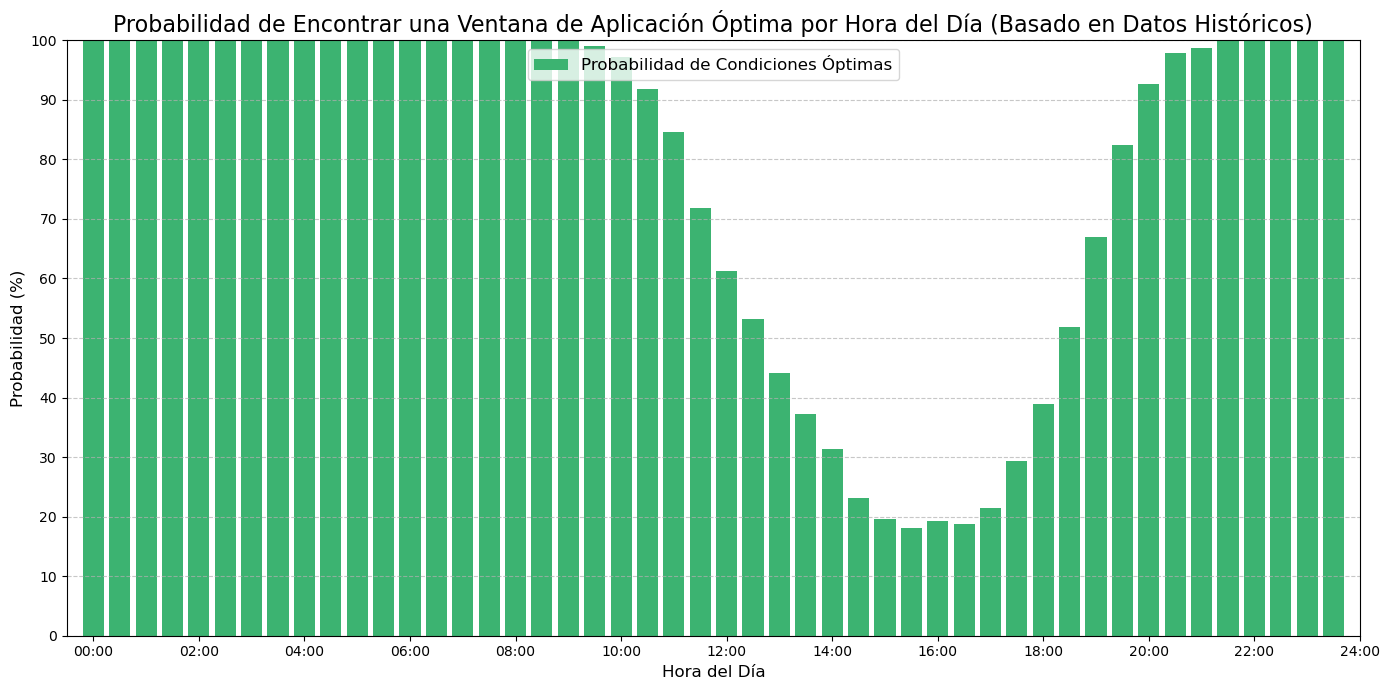

In [29]:
# Visualizar la Probabilidad de Ventanas Óptimas
plt.figure(figsize=(14, 7))
plt.bar(frecuencia_optima['hora_num'], frecuencia_optima['Probabilidad_Optima_%'], 
        width=0.4, align='center', color='mediumseagreen', label='Probabilidad de Condiciones Óptimas')

# Mejorar la estética del gráfico
plt.title('Probabilidad de Encontrar una Ventana de Aplicación Óptima por Hora del Día (Basado en Datos Históricos)', fontsize=16)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Probabilidad (%)', fontsize=12)
plt.xticks(ticks=range(0, 25, 2), labels=[f'{h:02d}:00' for h in range(0, 25, 2)])
plt.yticks(ticks=range(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xlim(-0.5, 24)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [30]:
import numpy as np

# Define el umbral
umbral = 75

# Creamos una máscara booleana: True si está por encima del umbral
mask = frecuencia_optima['Probabilidad_Optima_%'] > umbral

# Encontramos los "cortes" donde cambian los valores
cambios = mask != mask.shift()
grupos = cambios.cumsum()

# Agrupamos y buscamos SOLO los grupos donde la máscara es True (probabilidad > 75)
rango_horas = []
for _, group in frecuencia_optima.groupby(grupos):
    if group['Probabilidad_Optima_%'].iloc[0] > umbral:
        rango_horas.append((group['hora_del_dia'].iloc[0], group['hora_del_dia'].iloc[-1]))

if rango_horas:
    print("Rangos de horas con probabilidad superior al 75%:")
    for inicio, fin in rango_horas:
        print(f"  Desde {inicio} hasta {fin}")
else:
    print("No se encontró ningún rango horario con probabilidad superior al 75%.")



Rangos de horas con probabilidad superior al 75%:
  Desde 00:00:00 hasta 11:00:00
  Desde 19:30:00 hasta 23:30:00


### Por probabilidades

In [31]:
# Suavizar la curva de probabilidad con una media móvil
# Una ventana de 3 (equivalente a 1.5 horas) es un buen punto de partida para suavizar.
# 'center=True' asegura que el suavizado no tenga retardo.
frecuencia_optima['Prob_Suavizada_%'] = frecuencia_optima['Probabilidad_Optima_%'].rolling(window=3, center=True, min_periods=1).mean()

In [32]:
# Identificar los rangos fiables
# Definir un umbral de confianza. 75% es un umbral razonablemente alto.
UMBRAL_CONFIANZA = 70.0
# Usa hora_num en vez del índice para el análisis de rangos
hora_num_list = frecuencia_optima['hora_num'].tolist()
sobre_umbral = frecuencia_optima['Prob_Suavizada_%'] >= UMBRAL_CONFIANZA

rangos_optimos = []
in_range = False
start_time = None

for idx, is_over_threshold in enumerate(sobre_umbral):
    hora_actual = hora_num_list[idx]
    if is_over_threshold and not in_range:
        in_range = True
        start_time = hora_actual
    elif not is_over_threshold and in_range:
        in_range = False
        end_time = hora_num_list[idx - 1]  # Termina en el anterior que sí cumplía
        rangos_optimos.append({'inicio': start_time, 'fin': end_time})

# Cierra el último rango si termina en True
if in_range:
    rangos_optimos.append({'inicio': start_time, 'fin': hora_num_list[-1]})


In [33]:
def to_hhmm(hora_decimal):
    """Convierte una hora decimal (ej. 5.5) a formato HH:MM (ej. '05:30')."""
    horas = int(hora_decimal)
    minutos = int(round((hora_decimal * 60) % 60))
    return f"{horas:02d}:{minutos:02d}"

print("\n--- Conclusión del Análisis de Rango Óptimo Fiable ---")
if rangos_optimos:
    print(f"Se identificaron {len(rangos_optimos)} rango(s) de alta fiabilidad (probabilidad > {UMBRAL_CONFIANZA}%):")
    for i, rango in enumerate(rangos_optimos):
        print(f"  - Rango {i+1}: Desde las {to_hhmm(rango['inicio'])} hasta las {to_hhmm(rango['fin'])}.")
else:
    print(f"No se encontraron rangos de tiempo donde la probabilidad se mantuviera consistentemente por encima del {UMBRAL_CONFIANZA}%.")


--- Conclusión del Análisis de Rango Óptimo Fiable ---
Se identificaron 2 rango(s) de alta fiabilidad (probabilidad > 70.0%):
  - Rango 1: Desde las 00:00 hasta las 11:30.
  - Rango 2: Desde las 19:30 hasta las 23:30.


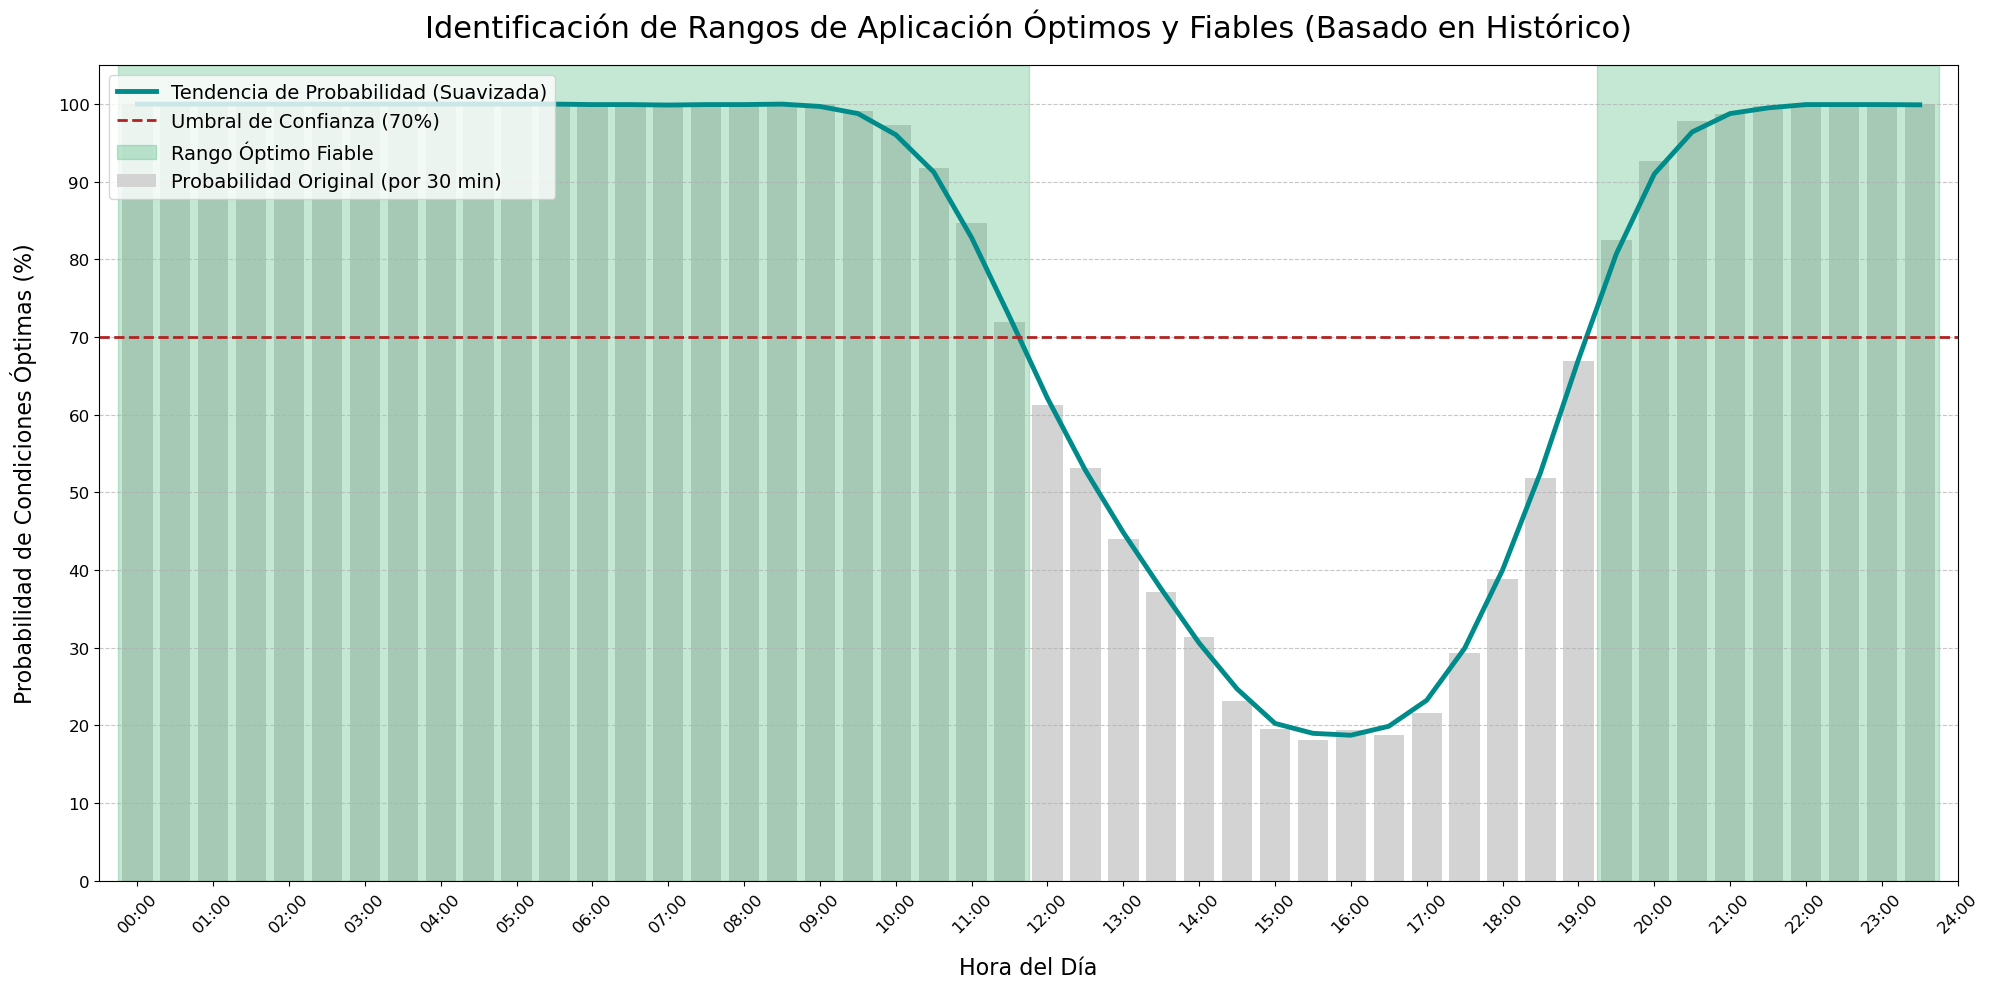

In [34]:
plt.figure(figsize=(20, 10))

# Dibujar la probabilidad original como barras (usar hora_num como eje X)
plt.bar(frecuencia_optima['hora_num'], frecuencia_optima['Probabilidad_Optima_%'], 
        width=0.4, align='center', color='lightgray', label='Probabilidad Original (por 30 min)')

# Dibujar la curva suavizada (usar hora_num como eje X)
plt.plot(frecuencia_optima['hora_num'], frecuencia_optima['Prob_Suavizada_%'], 
         color='darkcyan', linewidth=3.5, label='Tendencia de Probabilidad (Suavizada)')

# Dibujar la línea de umbral
plt.axhline(y=UMBRAL_CONFIANZA, color='firebrick', linestyle='--', linewidth=2,
            label=f'Umbral de Confianza ({int(UMBRAL_CONFIANZA)}%)')

# Rango óptimo (como antes)
import matplotlib.patches as mpatches
rango_patch = mpatches.Patch(color='mediumseagreen', alpha=0.3, label='Rango Óptimo Fiable')
handles, labels = plt.gca().get_legend_handles_labels()
handles.insert(2, rango_patch)

# Sombrear los rangos óptimos fiables
for rango in rangos_optimos:
    plt.axvspan(rango['inicio'] - 0.25, rango['fin'] + 0.25, color='mediumseagreen', alpha=0.3)

# Mejorar la estética
plt.title('Identificación de Rangos de Aplicación Óptimos y Fiables (Basado en Histórico)', fontsize=22, pad=20)
plt.xlabel('Hora del Día', fontsize=16, labelpad=15)
plt.ylabel('Probabilidad de Condiciones Óptimas (%)', fontsize=16, labelpad=15)

# Eje X en horas
ticks_pos = range(0, 25, 1)
ticks_lab = [f'{h:02d}:00' for h in ticks_pos]
plt.xticks(ticks=ticks_pos, labels=ticks_lab, fontsize=12, rotation=45)

plt.yticks(ticks=range(0, 111, 10), fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(handles=handles, fontsize=14, loc='upper left')
plt.xlim(-0.5, 24)
plt.ylim(0, 105)
plt.tight_layout()
plt.show()


### Estadisticamente diferenciados

In [41]:
print(df_analisis.head())

                     temperatura media  humedad  viento  lluvia hora_del_dia  \
datetime                                                                       
2024-01-01 00:30:00               21.8       81     4.8     0.0     00:30:00   
2024-01-01 01:00:00               21.7       81     4.8     0.0     01:00:00   
2024-01-01 01:30:00               21.4       82     4.8     0.0     01:30:00   
2024-01-01 02:00:00               21.2       83     4.8     0.0     02:00:00   
2024-01-01 02:30:00               21.1       84     4.8     0.0     02:30:00   

                     Condicion_Optima  
datetime                               
2024-01-01 00:30:00              True  
2024-01-01 01:00:00              True  
2024-01-01 01:30:00              True  
2024-01-01 02:00:00              True  
2024-01-01 02:30:00              True  


In [37]:
# df es tu DataFrame original con datetime index y columna 'Condicion_Optima' (0 o 1)
df_analisis_new = df_analisis.copy()
df_analisis_new['Condicion_Optima'] = df_analisis_new['Condicion_Optima'].astype(int)
ts = df_analisis_new['Condicion_Optima'].asfreq('30T').fillna(0)

# ADF: definir estaciónariedad (requisito para ARIMA)
print('ADF p-value:', adfuller(ts)[1])


ADF p-value: 1.2324189961030518e-18


#### Usando statsforecast

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

warnings.filterwarnings('ignore')


In [ ]:
df_sf = df_analisis_new.reset_index().rename(columns={
    'datetime': 'ds',
    'Condicion_Optima': 'y'
})
df_sf['unique_id'] = 'u1'                    # mismo ID para toda la serie
df_sf = df_sf[['unique_id', 'ds', 'y']]

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

sf = StatsForecast(
    models=[AutoARIMA(season_length=48)],
    freq='30T',
    n_jobs=-1,
    verbose=True
)

# Ajustar el modelo
sf.fit(df_sf)

StatsForecast(models=[AutoARIMA])

In [ ]:
# 3. Obtener la serie ajustada (in‑sample) con forecast()
fcst = sf.forecast(df=df_sf, h=0, fitted=True)

# 4. Analizar el resultado
# fcst tendrá columnas: ['unique_id', 'ds', 'AutoARIMA'] con valores fitted
print(fcst.head())

Forecast: 100%|██████████| 1/1 [2:01:08<00:00, 7268.49s/it]


ValueError: need at least one array to concatenate

In [ ]:
# Agregar hora decimal
fcst['hora_num'] = fcst['ds'].dt.hour + fcst['ds'].dt.minute / 60

df_hourly = fcst.groupby('hora_num')['AutoARIMA'].mean().reset_index()

,unique_id,ds,y
0,u1,2024-01-01 00:30:00,1
1,u1,2024-01-01 01:00:00,1
2,u1,2024-01-01 01:30:00,1
3,u1,2024-01-01 02:00:00,1
4,u1,2024-01-01 02:30:00,1
...,...,...,...
26317,u1,2025-07-04 09:30:00,1
26318,u1,2025-07-04 10:00:00,1
26319,u1,2025-07-04 10:30:00,1
26320,u1,2025-07-04 11:00:00,1


In [ ]:
# Agregar hora decimal
fcst['hora_num'] = fcst['ds'].dt.hour + fcst['ds'].dt.minute / 60

df_hourly = fcst.groupby('hora_num')['AutoARIMA'].mean().reset_index()

In [ ]:
# 7. Definir umbral (ej. percentil 75) y obtener franjas óptimas
UMBRAL = df_hourly['fitted'].quantile(0.75)
hour_nums = df_hourly['hora_num']
mask = df_hourly['fitted'] >= UMBRAL

rangos = []
in_range = False
start = None

for idx, over in enumerate(mask):
    hora = hour_nums.iloc[idx]
    if over and not in_range:
        in_range = True
        start = hora
    elif not over and in_range:
        in_range = False
        rangos.append((start, hour_nums.iloc[idx-1]))
if in_range:
    rangos.append((start, hour_nums.iloc[-1]))

print("Umbral ajustado (75%):", UMBRAL)
print("Franjas horario óptimas (SARIMAX):")
for ini, fin in rangos:
    print(f"  Desde {ini:.2f} hasta {fin:.2f} horas")

# 8. Graficar resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df_hourly['hora_num'], df_hourly['fitted'], color='darkcyan', lw=2, label='Prob Ajustada SARIMAX')
plt.axhline(UMBRAL, color='firebrick', linestyle='--', label='Umbral 75%')
for ini, fin in rangos:
    plt.axvspan(ini, fin, color='mediumseagreen', alpha=0.3)

plt.xticks(range(0,25))
plt.xlabel('Hora del Día')
plt.ylabel('Probabilidad ajustada de condiciones óptimas')
plt.title('Franjas Horarias Óptimas (SARIMAX)')
plt.legend()
plt.grid(True)
plt.show()

#### Usando LSTM

In [66]:
print(df.head)

<bound method NDFrame.head of                      temperatura media  humedad  viento  lluvia hora_del_dia  \
datetime                                                                       
2024-01-01 00:30:00               21.8       81     4.8     0.0     00:30:00   
2024-01-01 01:00:00               21.7       81     4.8     0.0     01:00:00   
2024-01-01 01:30:00               21.4       82     4.8     0.0     01:30:00   
2024-01-01 02:00:00               21.2       83     4.8     0.0     02:00:00   
2024-01-01 02:30:00               21.1       84     4.8     0.0     02:30:00   
...                                ...      ...     ...     ...          ...   
2025-07-04 09:30:00               23.1       77     1.6     0.0     09:30:00   
2025-07-04 10:00:00               24.2       75     1.6     0.0     10:00:00   
2025-07-04 10:30:00               25.1       73     3.2     0.0     10:30:00   
2025-07-04 11:00:00               25.7       70     3.2     0.0     11:00:00   
2025-07-04

In [67]:
print(df_analisis.head)

<bound method NDFrame.head of                      temperatura media  humedad  viento  lluvia hora_del_dia  \
datetime                                                                       
2024-01-01 00:30:00               21.8       81     4.8     0.0     00:30:00   
2024-01-01 01:00:00               21.7       81     4.8     0.0     01:00:00   
2024-01-01 01:30:00               21.4       82     4.8     0.0     01:30:00   
2024-01-01 02:00:00               21.2       83     4.8     0.0     02:00:00   
2024-01-01 02:30:00               21.1       84     4.8     0.0     02:30:00   
...                                ...      ...     ...     ...          ...   
2025-07-04 09:30:00               23.1       77     1.6     0.0     09:30:00   
2025-07-04 10:00:00               24.2       75     1.6     0.0     10:00:00   
2025-07-04 10:30:00               25.1       73     3.2     0.0     10:30:00   
2025-07-04 11:00:00               25.7       70     3.2     0.0     11:00:00   
2025-07-04

In [69]:
# Partimos de df_analisis con columna 'Condicion_Optima' booleana
df_LSTM = df_analisis.copy()
df_LSTM['Condicion_Optima'] = df_LSTM['Condicion_Optima'].astype(int)

# Variables cíclicas como antes
df_LSTM['hora_sin'] = np.sin(2*np.pi*(df_LSTM.index.hour + df_LSTM.index.minute/60)/24)
df_LSTM['hora_cos'] = np.cos(2*np.pi*(df_LSTM.index.hour + df_LSTM.index.minute/60)/24)

features = ['viento', 'temperatura media', 'humedad', 'lluvia', 'hora_sin', 'hora_cos']
X = df_LSTM[features].values
y = df_LSTM['Condicion_Optima'].values

In [70]:
def create_sequences_Xy(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

LOOKBACK = 96  # dos días

X_seq, y_seq = create_sequences_Xy(X, y, LOOKBACK)
print(X_seq.shape, y_seq.shape)  # (#muestras, 96, #features), (#muestras,)

(26226, 96, 6) (26226,)


In [71]:
split = int(len(X_seq)*0.9)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [72]:
# Escalamos las features (pero no y)
nsamples, ntimesteps, nfeat = X_train.shape
scaler = MinMaxScaler()
X_train_flat = X_train.reshape(-1, nfeat)
scaler.fit(X_train_flat)

X_train_scaled = scaler.transform(X_train_flat).reshape(nsamples, ntimesteps, nfeat)
X_test_scaled = scaler.transform(X_test.reshape(-1, nfeat)).reshape(X_test.shape)

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    GRU(75, return_sequences=True, input_shape=(LOOKBACK, nfeat)),
    Dropout(0.2),
    GRU(50),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Clasificación binaria
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

/home/alex/miniconda3/envs/rapids_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 96, 75)         │        18,675 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 75)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        19,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,776 (147.56 KB)

 Trainable params: 37,776 (147.56 KB)

 Non-trainable params: 0 (0.00 B)

None


In [74]:
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    callbacks=[early],
    verbose=1
)

Epoch 1/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.8411 - loss: 0.2952 - val_accuracy: 0.9199 - val_loss: 0.1852
Epoch 2/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9357 - loss: 0.1526 - val_accuracy: 0.9250 - val_loss: 0.1635
Epoch 3/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9372 - loss: 0.1400 - val_accuracy: 0.9322 - val_loss: 0.1550
Epoch 4/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9436 - loss: 0.1350 - val_accuracy: 0.9352 - val_loss: 0.1492
Epoch 5/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9455 - loss: 0.1277 - val_accuracy: 0.9377 - val_loss: 0.1424
Epoch 6/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9461 - loss: 0.1276 - val_accuracy: 0.9331 - val_loss: 0.1622
Epoch 7/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9510 - loss: 0.1144 - val_accuracy: 0.9420 - val_loss: 0.1414
Epoch 8/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9492 - loss: 0.1170 - 

In [75]:
# Predicción de probabilidades
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Acc:", accuracy_score(y_test, y_pred))
print("Prec:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Acc: 0.9553945863515059
Prec: 0.964022894521668
Recall: 0.9878508588186008
F1: 0.9757914338919925


In [76]:
# Crear un DataFrame con tiempos y predicción
times = df.index[LOOKBACK + split:]
df_pred = pd.DataFrame({
    'datetime': times,
    'prob_optima': y_pred_prob,
    'pred': y_pred
}).set_index('datetime')

# Puedes visualizar las horas con alta probabilidad:
df_pred[df_pred['prob_optima'] >= 0.8]

,prob_optima,pred
datetime,,
2025-05-10 20:30:00,0.985603,1
2025-05-10 21:00:00,0.998485,1
2025-05-10 21:30:00,0.999719,1
2025-05-10 22:00:00,0.999768,1
2025-05-10 22:30:00,0.999933,1
...,...,...
2025-07-04 09:30:00,0.999918,1
2025-07-04 10:00:00,0.999832,1
2025-07-04 10:30:00,0.999637,1


In [77]:
df_pred['hora'] = df_pred.index.hour
mean_by_hour = df_pred.groupby('hora')['prob_optima'].mean()
print(mean_by_hour)

hora
0     0.999953
1     0.999970
2     0.999974
3     0.999977
4     0.999975
5     0.999969
6     0.999959
7     0.999941
8     0.999880
9     0.999729
10    0.998938
11    0.986531
12    0.954885
13    0.861999
14    0.753653
15    0.639210
16    0.596779
17    0.627711
18    0.816381
19    0.944589
20    0.993160
21    0.999264
22    0.999797
23    0.999904
Name: prob_optima, dtype: float32


In [81]:
# Asegúrate de que tu índice es datetime
df_analisis_new = df_analisis.copy()
df_analisis_new['Condicion_Optima'] = df_analisis_new['Condicion_Optima'].astype(int)

# Extraer la hora exacta de cada observación (HH:MM:SS)
df_analisis_new['hora_min'] = df_analisis_new.index.time

In [82]:
# Agrupar por hora del día y calcular la media (probabilidad de condición óptima)
prob_horas = df_analisis_new.groupby(df_analisis_new.index.time)['Condicion_Optima'].mean()

In [86]:
import datetime

times = prob_horas.index
# Convierte cada time a un datetime (usa una fecha arbitraria, p.ej. 2000‑01‑01)
dtimes = [datetime.datetime(2000,1,1, t.hour, t.minute) for t in times]

In [88]:
import matplotlib.dates as mdates

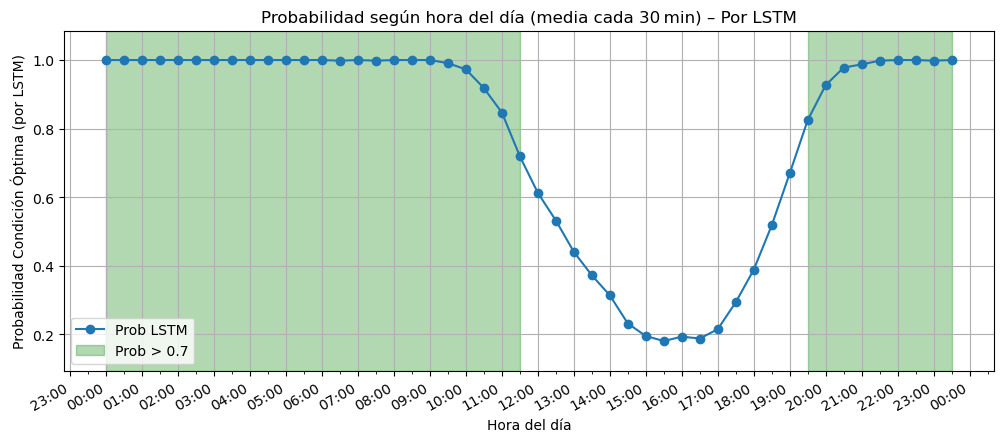

In [90]:
umbral = 0.7  # Ajusta según tu criterio

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dtimes, prob_horas.values, marker='o', label='Prob LSTM')

# Sombrear zonas donde prob_horas > umbral
ax.fill_between(
    dtimes,
    0, 1,  # zona completa del eje y, en coordenadas de ejes
    where=(prob_horas.values > umbral),
    transform=ax.get_xaxis_transform(),  # aplicación sobre toda la altura del eje
    color='green', alpha=0.3,
    label=f'Prob > {umbral}'
)

# Formatear el eje x como antes
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0,30]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()

ax.set_xlabel('Hora del día')
ax.set_ylabel('Probabilidad Condición Óptima (por LSTM)')
ax.set_title('Probabilidad según hora del día (media cada 30 min) – Por LSTM')
ax.legend()
plt.grid(True)
plt.show()

# Particionamiento de dataframe

## Creación de nuevas variables

In [60]:
# Feature Engineering (las características cíclicas siguen siendo valiosas)
df['hora_sin'] = np.sin(2 * np.pi * (df.index.hour + df.index.minute/60) / 24)
df['hora_cos'] = np.cos(2 * np.pi * (df.index.hour + df.index.minute/60) / 24)

# Seleccionar las columnas que usaremos (objetivo + exógenas)
features = ['viento', 'temperatura media', 'humedad', 'lluvia', 'hora_sin', 'hora_cos']
data = df[features]

## Particionamiento del train y test

In [61]:
# Dividir en entrenamiento y prueba ANTES de escalar para evitar fuga de datos
train_size = int(len(data) * 0.90)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

print(f"Tamaño del conjunto de entrenamiento: {len(train_data)}")
print(f"Tamaño del conjunto de prueba: {len(test_data)}")

Tamaño del conjunto de entrenamiento: 23689
Tamaño del conjunto de prueba: 2633


## Escalado de las variables

In [62]:
# Escalar los datos
scaler = MinMaxScaler()
# Ajustar el scaler SÓLO con los datos de entrenamiento
scaler.fit(train_data)

# Transformar ambos conjuntos
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [63]:
def create_sequences(data, lookback_window):
    """
    Crea secuencias de datos para modelos de series temporales.
    'data': array de numpy escalado.
    'lookback_window': cuántos pasos de tiempo pasados usar para la predicción.
    """
    X, y = [], []
    for i in range(len(data) - lookback_window):
        # La secuencia de entrada (X) son todos los features de la ventana
        X.append(data[i:(i + lookback_window)])
        # El objetivo (y) es el 'viento' del paso siguiente
        # El viento es la primera columna (índice 0)
        y.append(data[i + lookback_window, 0])
    return np.array(X), np.array(y)

# Definir la ventana de "mirada hacia atrás"
# Usaremos 2 días de datos pasados (48 * 2 = 96 pasos) para predecir el siguiente
LOOKBACK = 96

X_train, y_train = create_sequences(train_scaled, LOOKBACK)
X_test, y_test = create_sequences(test_scaled, LOOKBACK)

print(f"Forma de X_train: {X_train.shape}") # -> (muestras, timesteps, features)
print(f"Forma de y_train: {y_train.shape}") # -> (muestras,)

Forma de X_train: (23593, 96, 6)
Forma de y_train: (23593,)


In [64]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

n_splits = 5  # Usaremos 5 folds
tscv = TimeSeriesSplit(n_splits=n_splits)

rmse_scores = []
fold = 0

# Usaremos todo el dataset (train+test) para la validación cruzada
# y luego re-entrenaremos en todo el train para la predicción final
X_full = np.concatenate((X_train, X_test), axis=0)
y_full = np.concatenate((y_train, y_test), axis=0)

In [65]:
for train_index, val_index in tscv.split(X_full):
    fold += 1
    print(f"--- Fold {fold}/{n_splits} ---")
    
    # Dividir datos para este fold
    X_train_fold, X_val_fold = X_full[train_index], X_full[val_index]
    y_train_fold, y_val_fold = y_full[train_index], y_full[val_index]

    # Re-crear y compilar el modelo para un entrenamiento limpio en cada fold
    model_cv = Sequential([
        LSTM(units=50, input_shape=(X_train_fold.shape[1], X_train_fold.shape[2])),
        Dense(units=1)
    ])
    model_cv.compile(optimizer='adam', loss='mean_squared_error')
    
    # Entrenar
    model_cv.fit(X_train_fold, y_train_fold, epochs=20, batch_size=64, verbose=0)
    
    # Evaluar
    y_pred_scaled_fold = model_cv.predict(X_val_fold)
    
    # Des-escalar para calcular RMSE real
    temp_pred = np.zeros((len(y_pred_scaled_fold), X_full.shape[2]))
    temp_pred[:, 0] = y_pred_scaled_fold.flatten()
    y_pred_fold = scaler.inverse_transform(temp_pred)[:, 0]

    temp_real = np.zeros((len(y_val_fold), X_full.shape[2]))
    temp_real[:, 0] = y_val_fold.flatten()
    y_val_real_fold = scaler.inverse_transform(temp_real)[:, 0]

    rmse_fold = np.sqrt(mean_squared_error(y_val_real_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)
    print(f"RMSE del Fold {fold}: {rmse_fold:.4f}")

print(f"RMSE promedio: {np.mean(rmse_scores):.4f}")
print(f"Desviación estándar del RMSE: {np.std(rmse_scores):.4f}")

--- Fold 1/5 ---


/home/alex/miniconda3/envs/rapids_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1753272115.528693   19295 cuda_dnn.cc:529] Loaded cuDNN version 90300


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE del Fold 1: 1.3463
--- Fold 2/5 ---


/home/alex/miniconda3/envs/rapids_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE del Fold 2: 1.2119
--- Fold 3/5 ---


/home/alex/miniconda3/envs/rapids_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE del Fold 3: 1.1365
--- Fold 4/5 ---


/home/alex/miniconda3/envs/rapids_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
RMSE del Fold 4: 1.2555
--- Fold 5/5 ---


/home/alex/miniconda3/envs/rapids_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE del Fold 5: 1.1384
RMSE promedio: 1.2177
Desviación estándar del RMSE: 0.0786


# Entrenamiento de los modelos

## 1. Definición de Ambos Modelos

In [12]:
# --- Modelo LSTM Simple ---
model_simple = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])
model_simple.compile(optimizer='adam', loss='mean_squared_error')
print("--- Arquitectura del Modelo Simple ---")
model_simple.summary()

--- Arquitectura del Modelo Simple ---


c:\Users\ALEX\.conda\envs\ts_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# --- Modelo LSTM Mejorado (Más Profundo) ---
model_enhanced = Sequential([
    GRU(units=75, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])
model_enhanced.compile(optimizer='adam', loss='mean_squared_error')
print("\n--- Arquitectura del Modelo Mejorado ---")
model_enhanced.summary()



--- Arquitectura del Modelo Mejorado ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 96, 75)         │        18,675 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 75)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        19,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,776 (147.56 KB)

 Trainable params: 37,776 (147.56 KB)

 Non-trainable params: 0 (0.00 B)

## 2. Entrenamiento y Evaluación Separados

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [20]:

# --- Entrenar Modelo Simple ---
print("\n--- Entrenando Modelo LSTM Simple ---")
history_simple = model_simple.fit(
    X_train, 
    y_train, 
    epochs=100, # Un número alto, EarlyStopping decidirá cuándo parar
    batch_size=64,
    validation_split=0.1, # Usar 10% de los datos de entrenamiento para validación
    callbacks=[early_stopping], 
    verbose=1 # Muestra la barra de progreso
)


--- Entrenando Modelo LSTM Simple ---
Epoch 1/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0281 - val_loss: 0.0068
Epoch 2/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 3/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 4/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 5/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 6/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 7/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 8/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 9/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 10/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 11/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0048 - val_loss

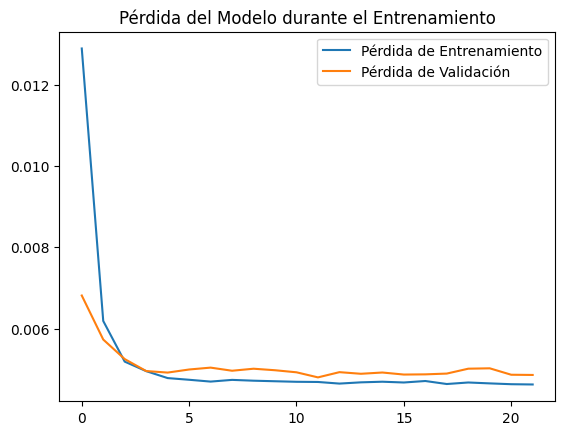

In [21]:
# Graficar la pérdida durante el entrenamiento
plt.plot(history_simple.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history_simple.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Modelo durante el Entrenamiento')
plt.legend()
plt.show()

In [15]:
# --- Entrenar Modelo Mejorado ---
print("\n--- Entrenando Modelo LSTM Mejorado ---")
history_enhanced = model_enhanced.fit(
    X_train, 
    y_train, 
    epochs=100, # Un número alto, EarlyStopping decidirá cuándo parar
    batch_size=64,
    validation_split=0.1, # Usar 10% de los datos de entrenamiento para validación
    callbacks=[early_stopping], 
    verbose=1 # Muestra la barra de progreso
)


--- Entrenando Modelo LSTM Mejorado ---
Epoch 1/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 0.0327 - val_loss: 0.0058
Epoch 2/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0077 - val_loss: 0.0052
Epoch 3/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 4/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 5/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 6/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 7/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 8/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 9/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 10/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 11/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.00

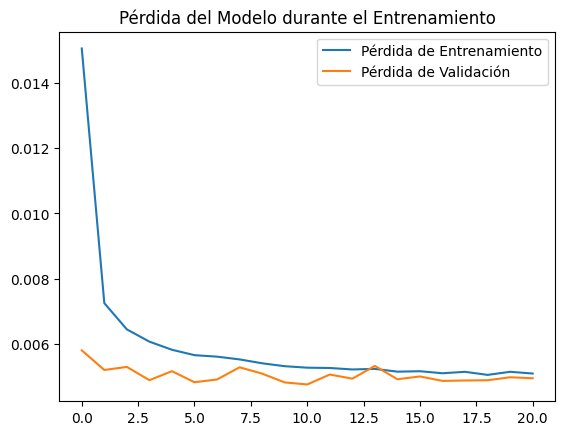

In [16]:
# Graficar la pérdida durante el entrenamiento
plt.plot(history_enhanced.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history_enhanced.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Modelo durante el Entrenamiento')
plt.legend()
plt.show()

In [ ]:
# --- Guardar Pesos y Configuración para Predicción con Incertidumbre ---
PATH_PESOS = "Modelos/pesos_viento_lstm.weights.h5"
PATH_MODELO_COMPLETO = "Modelos/modelo_viento_completo.keras"
PATH_SCALER = "Modelos/scaler_viento.joblib"
PATH_CONFIG = "Modelos/model_config.json"

print(f"\n--- Guardando los pesos del modelo en: {PATH_PESOS} ---")
model_enhanced.save_weights(PATH_PESOS) # Guardamos solo los pesos

print(f"\n--- Guardando el modelo COMPLETO en: {PATH_MODELO_COMPLETO} ---")
# Usamos el método de guardado estándar para el modelo completo
model_enhanced.save(PATH_MODELO_COMPLETO)

print(f"--- Guardando el scaler en: {PATH_SCALER} ---")
joblib.dump(scaler, PATH_SCALER)

import json
model_config_data = {
    "lookback": LOOKBACK,
    "features": features
}
with open(PATH_CONFIG, "w") as f:
    json.dump(model_config_data, f)
    
print(f"--- Configuración del modelo guardada en: {PATH_CONFIG} ---")


--- Guardando los pesos del modelo en: app_viento/pesos_viento_lstm.weights.h5 ---

--- Guardando el modelo COMPLETO en: app_viento/modelo_viento_completo.keras ---
--- Guardando el scaler en: app_viento/scaler_viento.joblib ---
--- Configuración del modelo guardada en: app_viento/model_config.json ---


## 3. Predicciones y Des-escalado

In [22]:
# Función auxiliar para des-escalar predicciones y evitar repetir código
def descale_predictions(y_pred_scaled, y_real_scaled, scaler, n_features):
    # Predicciones
    temp_pred = np.zeros((len(y_pred_scaled), n_features))
    temp_pred[:, 0] = y_pred_scaled.flatten()
    y_pred_descaled = scaler.inverse_transform(temp_pred)[:, 0]
    
    # Valores reales
    temp_real = np.zeros((len(y_real_scaled), n_features))
    temp_real[:, 0] = y_real_scaled.flatten()
    y_real_descaled = scaler.inverse_transform(temp_real)[:, 0]
    
    return y_pred_descaled, y_real_descaled

# Predicciones y des-escalado para ambos modelos
y_pred_simple_scaled = model_simple.predict(X_test)
y_pred_enhanced_scaled = model_enhanced.predict(X_test)

y_pred_simple, y_test_real = descale_predictions(y_pred_simple_scaled, y_test, scaler, X_train.shape[2])
y_pred_enhanced, _ = descale_predictions(y_pred_enhanced_scaled, y_test, scaler, X_train.shape[2])

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


## 4. Cálculo de Métricas Comparativas

In [23]:
metrics = {}
metrics['Simple'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test_real, y_pred_simple)),
    'MAE': mean_absolute_error(y_test_real, y_pred_simple)
}
metrics['Mejorado'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test_real, y_pred_enhanced)),
    'MAE': mean_absolute_error(y_test_real, y_pred_enhanced)
}

print("\n--- Métricas de Rendimiento en el Conjunto de Prueba ---")
print(f"Modelo Simple:   RMSE = {metrics['Simple']['RMSE']:.4f}, MAE = {metrics['Simple']['MAE']:.4f}")
print(f"Modelo Mejorado: RMSE = {metrics['Mejorado']['RMSE']:.4f}, MAE = {metrics['Mejorado']['MAE']:.4f}")


--- Métricas de Rendimiento en el Conjunto de Prueba ---
Modelo Simple:   RMSE = 1.0615, MAE = 0.8244
Modelo Mejorado: RMSE = 1.0854, MAE = 0.8483


## 5. Visualización Comparativa

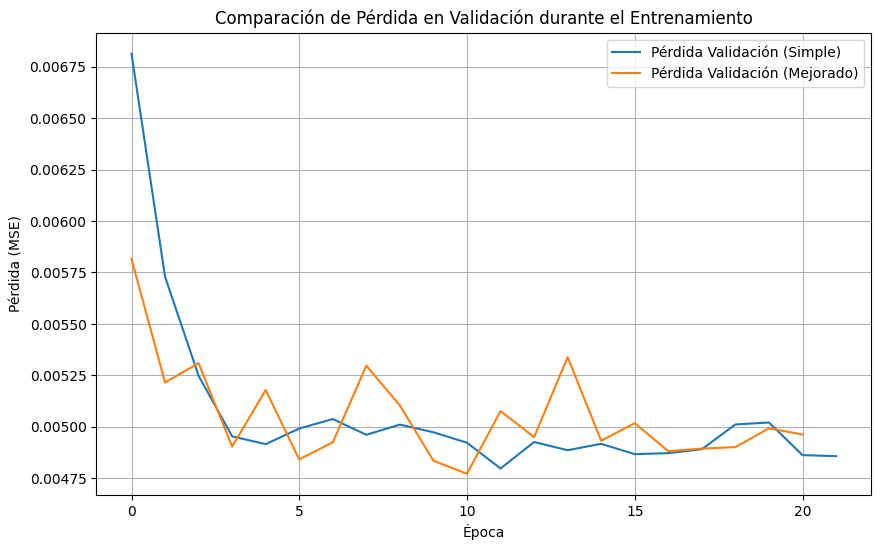

In [24]:
# --- Gráfico 1: Curvas de Pérdida de Validación ---
plt.figure(figsize=(10, 6))
plt.plot(history_simple.history['val_loss'], label='Pérdida Validación (Simple)')
plt.plot(history_enhanced.history['val_loss'], label='Pérdida Validación (Mejorado)')
plt.title('Comparación de Pérdida en Validación durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

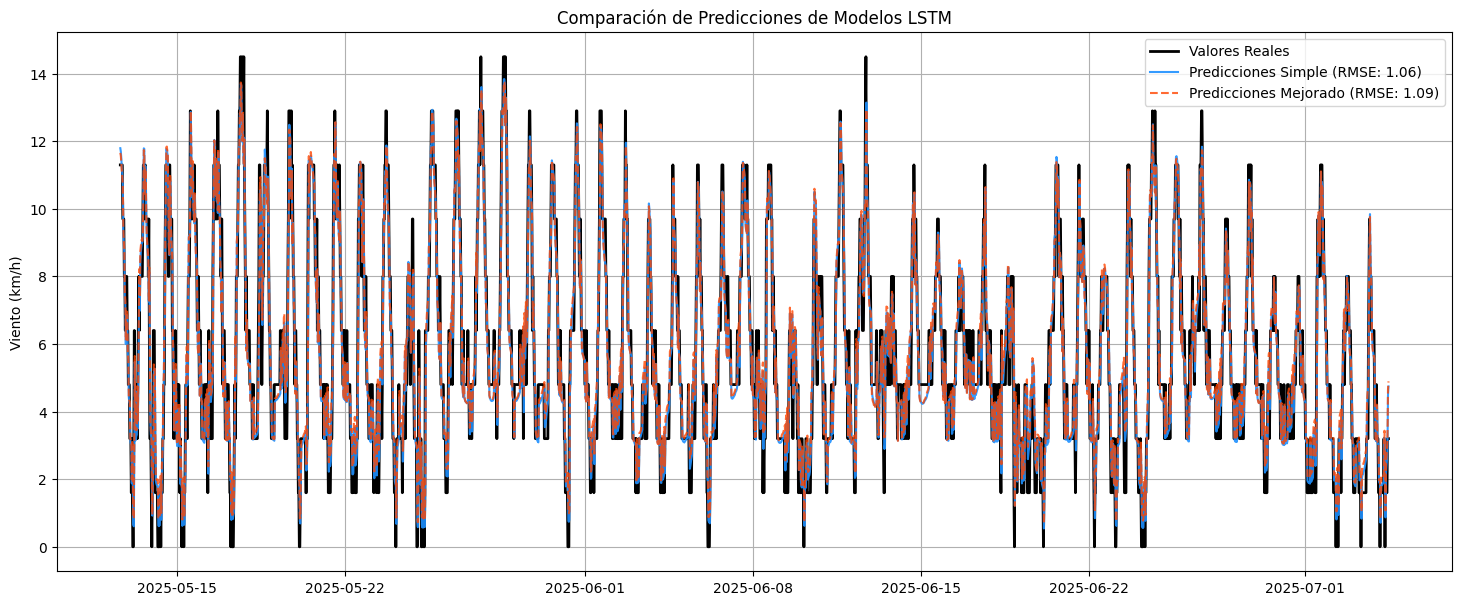

In [25]:
# --- Gráfico 2: Predicciones vs. Valores Reales ---
plt.figure(figsize=(18, 7))
plt.plot(test_data.index[LOOKBACK:], y_test_real, label='Valores Reales', color='black', linewidth=2)
plt.plot(test_data.index[LOOKBACK:], y_pred_simple, label=f"Predicciones Simple (RMSE: {metrics['Simple']['RMSE']:.2f})", color='dodgerblue', alpha=0.9)
plt.plot(test_data.index[LOOKBACK:], y_pred_enhanced, label=f"Predicciones Mejorado (RMSE: {metrics['Mejorado']['RMSE']:.2f})", color='orangered', alpha=0.8, linestyle='--')
plt.title('Comparación de Predicciones de Modelos LSTM')
plt.ylabel('Viento (km/h)')
plt.legend()
plt.grid(True)
plt.show()

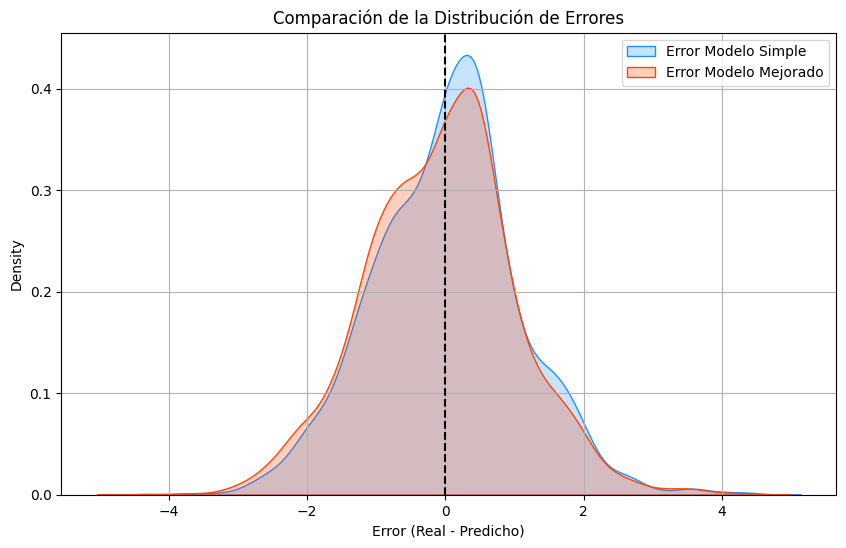

In [26]:
# --- Gráfico 3: Distribución de Residuos (Errores) ---
residuals_simple = y_test_real - y_pred_simple
residuals_enhanced = y_test_real - y_pred_enhanced

plt.figure(figsize=(10, 6))
sns.kdeplot(residuals_simple, label='Error Modelo Simple', color='dodgerblue', fill=True)
sns.kdeplot(residuals_enhanced, label='Error Modelo Mejorado', color='orangered', fill=True)
plt.title('Comparación de la Distribución de Errores')
plt.xlabel('Error (Real - Predicho)')
plt.axvline(0, color='black', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

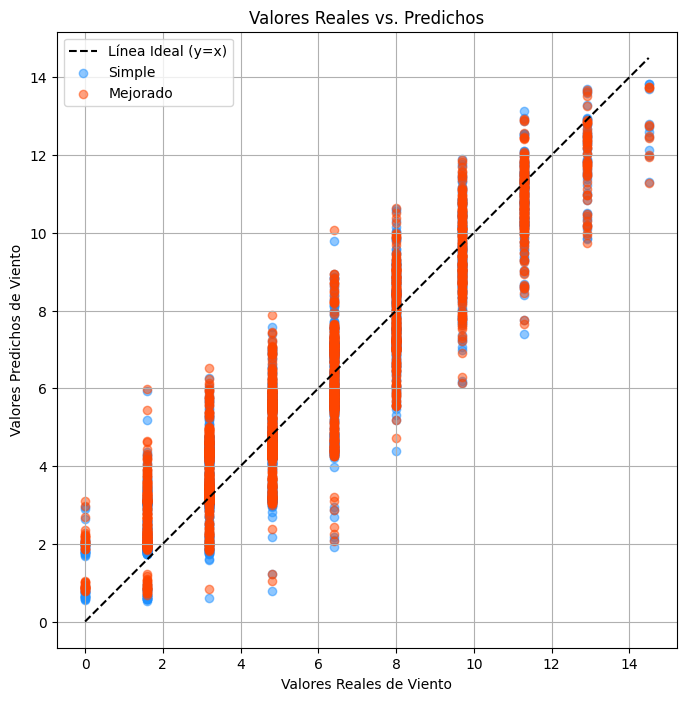

In [27]:
# --- Gráfico 4: Real vs. Predicho (Scatter Plot) ---
plt.figure(figsize=(8, 8))
max_val = max(y_test_real.max(), y_pred_simple.max(), y_pred_enhanced.max())
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--', label='Línea Ideal (y=x)')
plt.scatter(y_test_real, y_pred_simple, alpha=0.5, label='Simple', color='dodgerblue')
plt.scatter(y_test_real, y_pred_enhanced, alpha=0.5, label='Mejorado', color='orangered')
plt.title('Valores Reales vs. Predichos')
plt.xlabel('Valores Reales de Viento')
plt.ylabel('Valores Predichos de Viento')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

# Guardar el Modelo Ganador y el Scaler

In [ ]:
# Asegúrese de que el modelo que está guardando es el que eligió como ganador.
# En nuestro caso, es 'model_enhanced'.
modelo_ganador = model_enhanced

# Definir las rutas de guardado
PATH_MODELO = "Modelos/modelo_viento_lstm.keras"

print(f"\n--- Guardando el modelo en: {PATH_MODELO} ---")
modelo_ganador.save(PATH_MODELO)

print("\n¡Modeloguardado exitosamente!")


--- Guardando el modelo en: app_viento/modelo_viento_lstm.keras ---

¡Modeloguardado exitosamente!


In [ ]:
# También es buena práctica guardar una muestra de los datos de entrada
# para recordar el formato exacto que espera el modelo.
# Guardaremos los nombres de las columnas y el valor de LOOKBACK.
import json
model_config = {
    "lookback": LOOKBACK,
    "features": features
}
with open("Modelos/model_config.json", "w") as f:
    json.dump(model_config, f)
    
print("--- Configuración del modelo guardada en: model_config.json ---")

--- Configuración del modelo guardada en: model_config.json ---
